In [1]:
import os
import cv2
import torch
import helper
import time
import random
from tqdm import tqdm
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
import torchvision
import matplotlib.pyplot as plt

In [2]:
# define the path to the images and masks dataset
image_dataset_path = "dataset\\PPL"
mask_dataset_path = "dataset\\BSD"

# define the test split
test_split = 0.10

# determine the device to be used for training and evaluation
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.backends.cudnn.benchmark = True

#initialize learning rate, number of epochs to train for, and the batch size
init_lr = 1e-4
num_epochs = 500
batch_size = 5

# define the input image dimensions
input_image_width = 400
input_image_height = 400

# define the path to the base output directory
base_output = "output"

# define the path to the output serialized model, model training plot, and testing image paths
model_path = os.path.join(base_output, "unet_model.pth")
plot_path = os.path.sep.join([base_output, "plot.png"])
test_paths = os.path.sep.join([base_output, "test_paths.txt"])

In [3]:
# load the image and mask filepaths in a sorted manner
imagePaths = os.listdir(image_dataset_path)
maskPaths = os.listdir(mask_dataset_path)
imageprefix = image_dataset_path + "\\"
maskprefix = mask_dataset_path + "\\"
imagePaths = [imageprefix + x for x in imagePaths]
maskPaths = [maskprefix + x for x in maskPaths]
# partition the data into training and testing splits using 85% of the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths, test_size=test_split, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# write the testing image paths to disk so that we can use then when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(test_paths, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms):
        # store the image and mask filepaths, and augmentation transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)
    def __getitem__(self, idx):
        img_path = self.imagePaths[idx]
        mask_path = self.maskPaths[idx]
        img_1 = np.array(Image.open(img_path).convert("RGB"), dtype = np.float32) / 255.
        img_2_path = img_path.replace("PPL", "XPL")
        img_2 = np.array(Image.open(img_2_path).convert("RGB"), dtype = np.float32) / 255.
        image = np.concatenate((img_1, img_2), axis=-1)
        mask = np.array(Image.open(mask_path).convert("L"), dtype = np.float32) / 255.
        if self.transforms is not None:
            seed = np.random.randint(2147483647) 
            random.seed(seed) 
            torch.manual_seed(seed) 
            image = self.transforms(image)
            random.seed(seed) 
            torch.manual_seed(seed)
            mask = self.transforms(mask)
        return (image, mask)

In [5]:
# define transformations
transforms_ = transforms.Compose([transforms.ToTensor(), 
                                       transforms.RandomRotation(180),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip()]) 

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks, transforms=transforms_)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks, transforms=transforms_)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True, batch_size=batch_size, pin_memory = True if device == "cuda" else False)
testLoader = DataLoader(testDS, shuffle=False, batch_size=batch_size, pin_memory= True if device == "cuda" else False)

[INFO] found 199 examples in the training set...
[INFO] found 23 examples in the test set...


In [6]:
# Run this to test your data loader
(images, masks) = next(iter(trainLoader))

In [7]:
print(f'x = shape: {images.shape}; type: {images.dtype}')
print(f'y = shape: {masks.shape}; type: {masks.dtype}')
print(f'x = min: {images.min()}; max: {images.max()}')
print(f'y = min: {masks.min()}; max: {masks.max()}')

x = shape: torch.Size([5, 6, 400, 400]); type: torch.float32
y = shape: torch.Size([5, 1, 400, 400]); type: torch.float32
x = min: 0.0; max: 1.0
y = min: 0.0; max: 0.6941176652908325


<AxesSubplot:>

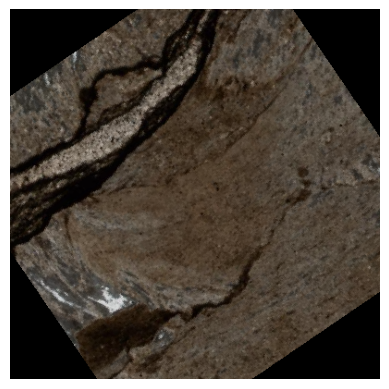

In [8]:
helper.imshow(images[0][0:3,:,:], normalize=False)

<AxesSubplot:>

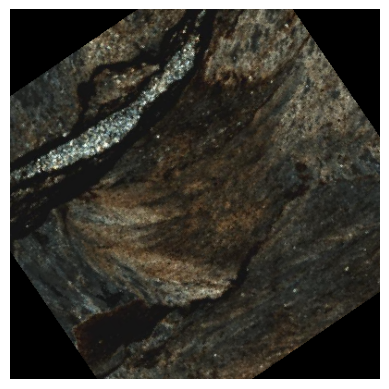

In [9]:
helper.imshow(images[0][3:6,:,:], normalize=False)

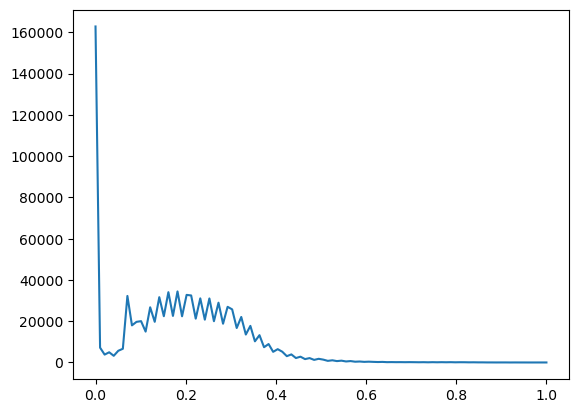

In [10]:
hist = images[0].histc()
images_min = images[0].min().item()
images_max = images[0].max().item()
plt.plot(torch.linspace(images_min, images_max, len(hist)), hist)
plt.show()

<AxesSubplot:>

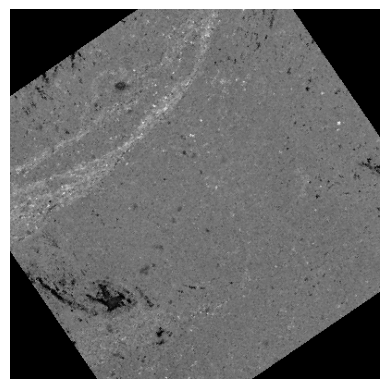

In [11]:
helper.imshow(masks[0], normalize=False, cmap='gray')

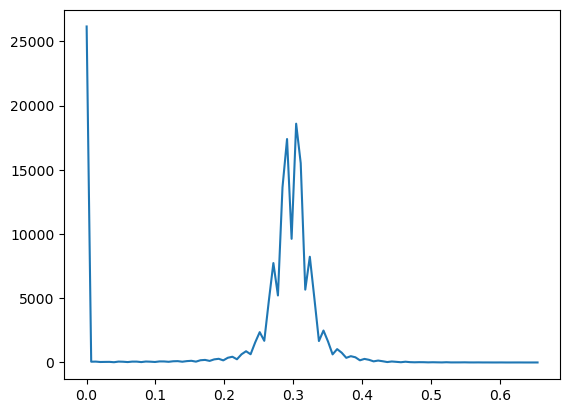

In [12]:
hist = masks[0].histc()
masks_min = masks[0].min().item()
masks_max = masks[0].max().item()
plt.plot(torch.linspace(masks_min, masks_max, len(hist)), hist)
plt.show()

In [13]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(
        self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # make sure the input is dividable by 16
        
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
            
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
            
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            
            # to solve the problem of input not dividable by 16
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
                
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            
        return self.final_conv(x)

In [14]:
# initialize our UNet model
unet = UNet(in_channels=6, out_channels=1).to(device)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss() # change to cross entropy loss for multi class
opt = Adam(unet.parameters(), lr=init_lr)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // batch_size
testSteps = len(testDS) // batch_size
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [15]:
pred = unet(images.to(device))

In [16]:
loss = lossFunc(pred, masks.to(device))
print(loss)

tensor(0.8660, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [17]:
new_pred = pred.cpu()

In [18]:
new_pred = torch.sigmoid(new_pred)

<AxesSubplot:>

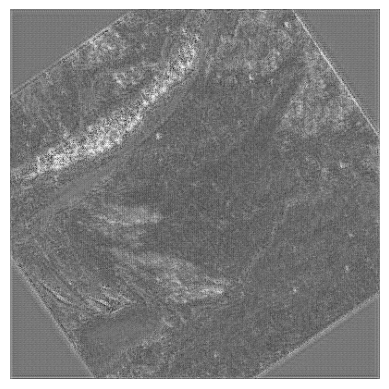

In [19]:
helper.imshow(new_pred[0].detach(), normalize=False, cmap='gray')

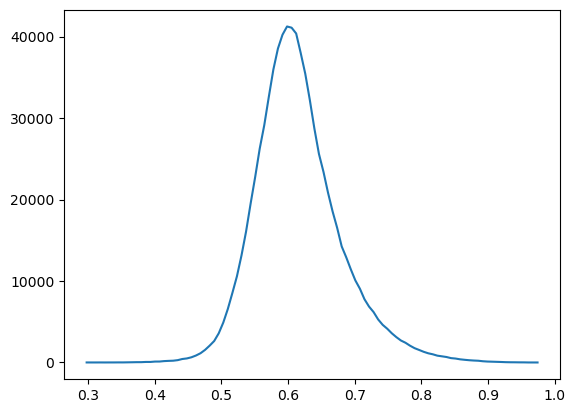

In [20]:
hist = new_pred.histc()
new_pred_min = new_pred.min().item()
new_pred_max = new_pred.max().item()
plt.plot(torch.linspace(new_pred_min, new_pred_max, len(hist)), hist)
plt.show()

[INFO] training the network...


  0%|▏                                                                               | 1/500 [00:42<5:54:13, 42.59s/it]

[INFO] EPOCH: 1/500
Train loss: 0.723886, Test loss: 1.1646


  0%|▎                                                                               | 2/500 [01:01<3:57:46, 28.65s/it]

[INFO] EPOCH: 2/500
Train loss: 0.600396, Test loss: 0.7342


  1%|▍                                                                               | 3/500 [01:20<3:19:22, 24.07s/it]

[INFO] EPOCH: 3/500
Train loss: 0.583509, Test loss: 0.7930


  1%|▋                                                                               | 4/500 [01:39<3:02:52, 22.12s/it]

[INFO] EPOCH: 4/500
Train loss: 0.570620, Test loss: 0.7296


  1%|▊                                                                               | 5/500 [01:59<2:55:37, 21.29s/it]

[INFO] EPOCH: 5/500
Train loss: 0.557220, Test loss: 0.6815


  1%|▉                                                                               | 6/500 [02:18<2:51:04, 20.78s/it]

[INFO] EPOCH: 6/500
Train loss: 0.551171, Test loss: 0.6816


  1%|█                                                                               | 7/500 [02:38<2:47:57, 20.44s/it]

[INFO] EPOCH: 7/500
Train loss: 0.543797, Test loss: 0.6699


  2%|█▎                                                                              | 8/500 [02:58<2:45:52, 20.23s/it]

[INFO] EPOCH: 8/500
Train loss: 0.544345, Test loss: 0.6898


  2%|█▍                                                                              | 9/500 [03:18<2:44:42, 20.13s/it]

[INFO] EPOCH: 9/500
Train loss: 0.536062, Test loss: 0.6593


  2%|█▌                                                                             | 10/500 [03:38<2:43:40, 20.04s/it]

[INFO] EPOCH: 10/500
Train loss: 0.531121, Test loss: 0.6548


  2%|█▋                                                                             | 11/500 [03:57<2:42:38, 19.96s/it]

[INFO] EPOCH: 11/500
Train loss: 0.528797, Test loss: 0.6503


  2%|█▉                                                                             | 12/500 [04:17<2:42:01, 19.92s/it]

[INFO] EPOCH: 12/500
Train loss: 0.527193, Test loss: 0.6479


  3%|██                                                                             | 13/500 [04:37<2:41:31, 19.90s/it]

[INFO] EPOCH: 13/500
Train loss: 0.523124, Test loss: 0.6423


  3%|██▏                                                                            | 14/500 [04:57<2:41:09, 19.90s/it]

[INFO] EPOCH: 14/500
Train loss: 0.521260, Test loss: 0.6492


  3%|██▎                                                                            | 15/500 [05:17<2:40:56, 19.91s/it]

[INFO] EPOCH: 15/500
Train loss: 0.521814, Test loss: 0.6409


  3%|██▌                                                                            | 16/500 [05:37<2:40:24, 19.89s/it]

[INFO] EPOCH: 16/500
Train loss: 0.519944, Test loss: 0.6352


  3%|██▋                                                                            | 17/500 [05:57<2:40:05, 19.89s/it]

[INFO] EPOCH: 17/500
Train loss: 0.518171, Test loss: 0.6469


  4%|██▊                                                                            | 18/500 [06:17<2:42:00, 20.17s/it]

[INFO] EPOCH: 18/500
Train loss: 0.515789, Test loss: 0.6298


  4%|███                                                                            | 19/500 [06:37<2:40:55, 20.07s/it]

[INFO] EPOCH: 19/500
Train loss: 0.514285, Test loss: 0.6346


  4%|███▏                                                                           | 20/500 [06:57<2:39:56, 19.99s/it]

[INFO] EPOCH: 20/500
Train loss: 0.518222, Test loss: 0.6324


  4%|███▎                                                                           | 21/500 [07:17<2:39:30, 19.98s/it]

[INFO] EPOCH: 21/500
Train loss: 0.515798, Test loss: 0.6296


  4%|███▍                                                                           | 22/500 [07:37<2:38:54, 19.95s/it]

[INFO] EPOCH: 22/500
Train loss: 0.515089, Test loss: 0.6399


  5%|███▋                                                                           | 23/500 [07:57<2:38:07, 19.89s/it]

[INFO] EPOCH: 23/500
Train loss: 0.514828, Test loss: 0.6323


  5%|███▊                                                                           | 24/500 [08:16<2:37:29, 19.85s/it]

[INFO] EPOCH: 24/500
Train loss: 0.518599, Test loss: 0.6300


  5%|███▉                                                                           | 25/500 [08:36<2:37:03, 19.84s/it]

[INFO] EPOCH: 25/500
Train loss: 0.515498, Test loss: 0.6374


  5%|████                                                                           | 26/500 [08:56<2:36:37, 19.83s/it]

[INFO] EPOCH: 26/500
Train loss: 0.515734, Test loss: 0.6304


  5%|████▎                                                                          | 27/500 [09:16<2:36:43, 19.88s/it]

[INFO] EPOCH: 27/500
Train loss: 0.512350, Test loss: 0.6334


  6%|████▍                                                                          | 28/500 [09:36<2:36:15, 19.86s/it]

[INFO] EPOCH: 28/500
Train loss: 0.514628, Test loss: 0.6240


  6%|████▌                                                                          | 29/500 [09:56<2:36:05, 19.88s/it]

[INFO] EPOCH: 29/500
Train loss: 0.511304, Test loss: 0.6386


  6%|████▋                                                                          | 30/500 [10:16<2:35:37, 19.87s/it]

[INFO] EPOCH: 30/500
Train loss: 0.511948, Test loss: 0.6485


  6%|████▉                                                                          | 31/500 [10:35<2:35:00, 19.83s/it]

[INFO] EPOCH: 31/500
Train loss: 0.516438, Test loss: 0.6352


  6%|█████                                                                          | 32/500 [10:55<2:34:21, 19.79s/it]

[INFO] EPOCH: 32/500
Train loss: 0.514361, Test loss: 0.6261


  7%|█████▏                                                                         | 33/500 [11:15<2:34:19, 19.83s/it]

[INFO] EPOCH: 33/500
Train loss: 0.514871, Test loss: 0.6204


  7%|█████▎                                                                         | 34/500 [11:35<2:33:56, 19.82s/it]

[INFO] EPOCH: 34/500
Train loss: 0.512613, Test loss: 0.6250


  7%|█████▌                                                                         | 35/500 [11:55<2:33:39, 19.83s/it]

[INFO] EPOCH: 35/500
Train loss: 0.514412, Test loss: 0.6324


  7%|█████▋                                                                         | 36/500 [12:14<2:33:10, 19.81s/it]

[INFO] EPOCH: 36/500
Train loss: 0.514675, Test loss: 0.6153


  7%|█████▊                                                                         | 37/500 [12:34<2:33:01, 19.83s/it]

[INFO] EPOCH: 37/500
Train loss: 0.511394, Test loss: 0.6428


  8%|██████                                                                         | 38/500 [12:54<2:33:02, 19.88s/it]

[INFO] EPOCH: 38/500
Train loss: 0.510927, Test loss: 0.6223


  8%|██████▏                                                                        | 39/500 [13:14<2:32:37, 19.86s/it]

[INFO] EPOCH: 39/500
Train loss: 0.515066, Test loss: 0.6414


  8%|██████▎                                                                        | 40/500 [13:34<2:32:11, 19.85s/it]

[INFO] EPOCH: 40/500
Train loss: 0.513924, Test loss: 0.6347


  8%|██████▍                                                                        | 41/500 [13:54<2:31:52, 19.85s/it]

[INFO] EPOCH: 41/500
Train loss: 0.510634, Test loss: 0.6332


  8%|██████▋                                                                        | 42/500 [14:13<2:31:11, 19.81s/it]

[INFO] EPOCH: 42/500
Train loss: 0.515247, Test loss: 0.6471


  9%|██████▊                                                                        | 43/500 [14:33<2:30:58, 19.82s/it]

[INFO] EPOCH: 43/500
Train loss: 0.511810, Test loss: 0.6292


  9%|██████▉                                                                        | 44/500 [14:53<2:30:36, 19.82s/it]

[INFO] EPOCH: 44/500
Train loss: 0.512006, Test loss: 0.6154


  9%|███████                                                                        | 45/500 [15:13<2:30:27, 19.84s/it]

[INFO] EPOCH: 45/500
Train loss: 0.512681, Test loss: 0.6411


  9%|███████▎                                                                       | 46/500 [15:33<2:30:20, 19.87s/it]

[INFO] EPOCH: 46/500
Train loss: 0.507722, Test loss: 0.6266


  9%|███████▍                                                                       | 47/500 [15:53<2:29:54, 19.86s/it]

[INFO] EPOCH: 47/500
Train loss: 0.509767, Test loss: 0.6350


 10%|███████▌                                                                       | 48/500 [16:13<2:29:45, 19.88s/it]

[INFO] EPOCH: 48/500
Train loss: 0.507129, Test loss: 0.6225


 10%|███████▋                                                                       | 49/500 [16:33<2:29:11, 19.85s/it]

[INFO] EPOCH: 49/500
Train loss: 0.511463, Test loss: 0.6338


 10%|███████▉                                                                       | 50/500 [16:52<2:28:35, 19.81s/it]

[INFO] EPOCH: 50/500
Train loss: 0.513838, Test loss: 0.6291


 10%|████████                                                                       | 51/500 [17:12<2:28:29, 19.84s/it]

[INFO] EPOCH: 51/500
Train loss: 0.511923, Test loss: 0.6306


 10%|████████▏                                                                      | 52/500 [17:32<2:28:11, 19.85s/it]

[INFO] EPOCH: 52/500
Train loss: 0.509689, Test loss: 0.6200


 11%|████████▎                                                                      | 53/500 [17:52<2:28:05, 19.88s/it]

[INFO] EPOCH: 53/500
Train loss: 0.507568, Test loss: 0.6195


 11%|████████▌                                                                      | 54/500 [18:12<2:27:35, 19.85s/it]

[INFO] EPOCH: 54/500
Train loss: 0.511181, Test loss: 0.6351


 11%|████████▋                                                                      | 55/500 [18:31<2:26:56, 19.81s/it]

[INFO] EPOCH: 55/500
Train loss: 0.516164, Test loss: 0.6315


 11%|████████▊                                                                      | 56/500 [18:51<2:26:23, 19.78s/it]

[INFO] EPOCH: 56/500
Train loss: 0.512585, Test loss: 0.6470


 11%|█████████                                                                      | 57/500 [19:11<2:26:30, 19.84s/it]

[INFO] EPOCH: 57/500
Train loss: 0.511499, Test loss: 0.6260


 12%|█████████▏                                                                     | 58/500 [19:31<2:26:10, 19.84s/it]

[INFO] EPOCH: 58/500
Train loss: 0.511288, Test loss: 0.6209


 12%|█████████▎                                                                     | 59/500 [19:51<2:25:51, 19.85s/it]

[INFO] EPOCH: 59/500
Train loss: 0.511265, Test loss: 0.6216


 12%|█████████▍                                                                     | 60/500 [20:11<2:25:20, 19.82s/it]

[INFO] EPOCH: 60/500
Train loss: 0.512859, Test loss: 0.6322


 12%|█████████▋                                                                     | 61/500 [20:30<2:24:54, 19.81s/it]

[INFO] EPOCH: 61/500
Train loss: 0.511068, Test loss: 0.6242


 12%|█████████▊                                                                     | 62/500 [20:50<2:24:41, 19.82s/it]

[INFO] EPOCH: 62/500
Train loss: 0.511667, Test loss: 0.6219


 13%|█████████▉                                                                     | 63/500 [21:10<2:24:40, 19.86s/it]

[INFO] EPOCH: 63/500
Train loss: 0.511457, Test loss: 0.6180


 13%|██████████                                                                     | 64/500 [21:31<2:26:15, 20.13s/it]

[INFO] EPOCH: 64/500
Train loss: 0.507942, Test loss: 0.6260


 13%|██████████▎                                                                    | 65/500 [21:51<2:25:29, 20.07s/it]

[INFO] EPOCH: 65/500
Train loss: 0.507007, Test loss: 0.6214


 13%|██████████▍                                                                    | 66/500 [22:11<2:24:39, 20.00s/it]

[INFO] EPOCH: 66/500
Train loss: 0.511821, Test loss: 0.6233


 13%|██████████▌                                                                    | 67/500 [22:31<2:23:53, 19.94s/it]

[INFO] EPOCH: 67/500
Train loss: 0.511370, Test loss: 0.6337


 14%|██████████▋                                                                    | 68/500 [22:50<2:23:14, 19.89s/it]

[INFO] EPOCH: 68/500
Train loss: 0.510909, Test loss: 0.6260


 14%|██████████▉                                                                    | 69/500 [23:10<2:23:07, 19.92s/it]

[INFO] EPOCH: 69/500
Train loss: 0.508536, Test loss: 0.6326


 14%|███████████                                                                    | 70/500 [23:30<2:22:28, 19.88s/it]

[INFO] EPOCH: 70/500
Train loss: 0.513759, Test loss: 0.6156


 14%|███████████▏                                                                   | 71/500 [23:50<2:21:59, 19.86s/it]

[INFO] EPOCH: 71/500
Train loss: 0.511820, Test loss: 0.6316


 14%|███████████▍                                                                   | 72/500 [24:10<2:21:40, 19.86s/it]

[INFO] EPOCH: 72/500
Train loss: 0.508522, Test loss: 0.6313


 15%|███████████▌                                                                   | 73/500 [24:30<2:21:08, 19.83s/it]

[INFO] EPOCH: 73/500
Train loss: 0.510415, Test loss: 0.6351


 15%|███████████▋                                                                   | 74/500 [24:49<2:20:59, 19.86s/it]

[INFO] EPOCH: 74/500
Train loss: 0.510297, Test loss: 0.6296


 15%|███████████▊                                                                   | 75/500 [25:09<2:20:50, 19.88s/it]

[INFO] EPOCH: 75/500
Train loss: 0.509272, Test loss: 0.6198


 15%|████████████                                                                   | 76/500 [25:29<2:20:15, 19.85s/it]

[INFO] EPOCH: 76/500
Train loss: 0.512473, Test loss: 0.6353


 15%|████████████▏                                                                  | 77/500 [25:49<2:20:08, 19.88s/it]

[INFO] EPOCH: 77/500
Train loss: 0.505318, Test loss: 0.6328


 16%|████████████▎                                                                  | 78/500 [26:09<2:19:45, 19.87s/it]

[INFO] EPOCH: 78/500
Train loss: 0.509791, Test loss: 0.6340


 16%|████████████▍                                                                  | 79/500 [26:29<2:19:09, 19.83s/it]

[INFO] EPOCH: 79/500
Train loss: 0.511170, Test loss: 0.6291


 16%|████████████▋                                                                  | 80/500 [26:49<2:19:02, 19.86s/it]

[INFO] EPOCH: 80/500
Train loss: 0.507896, Test loss: 0.6234


 16%|████████████▊                                                                  | 81/500 [27:09<2:18:58, 19.90s/it]

[INFO] EPOCH: 81/500
Train loss: 0.511885, Test loss: 0.6294


 16%|████████████▉                                                                  | 82/500 [27:28<2:18:27, 19.87s/it]

[INFO] EPOCH: 82/500
Train loss: 0.511494, Test loss: 0.6270


 17%|█████████████                                                                  | 83/500 [27:48<2:17:55, 19.84s/it]

[INFO] EPOCH: 83/500
Train loss: 0.510440, Test loss: 0.6237


 17%|█████████████▎                                                                 | 84/500 [28:08<2:17:31, 19.83s/it]

[INFO] EPOCH: 84/500
Train loss: 0.509574, Test loss: 0.6383


 17%|█████████████▍                                                                 | 85/500 [28:30<2:20:56, 20.38s/it]

[INFO] EPOCH: 85/500
Train loss: 0.511710, Test loss: 0.6166


 17%|█████████████▌                                                                 | 86/500 [28:49<2:19:29, 20.22s/it]

[INFO] EPOCH: 86/500
Train loss: 0.509368, Test loss: 0.6348


 17%|█████████████▋                                                                 | 87/500 [29:09<2:18:38, 20.14s/it]

[INFO] EPOCH: 87/500
Train loss: 0.511264, Test loss: 0.6145


 18%|█████████████▉                                                                 | 88/500 [29:29<2:17:37, 20.04s/it]

[INFO] EPOCH: 88/500
Train loss: 0.513167, Test loss: 0.6196


 18%|██████████████                                                                 | 89/500 [29:49<2:16:42, 19.96s/it]

[INFO] EPOCH: 89/500
Train loss: 0.510573, Test loss: 0.6170


 18%|██████████████▏                                                                | 90/500 [30:09<2:16:11, 19.93s/it]

[INFO] EPOCH: 90/500
Train loss: 0.508514, Test loss: 0.6151


 18%|██████████████▍                                                                | 91/500 [30:29<2:15:29, 19.88s/it]

[INFO] EPOCH: 91/500
Train loss: 0.510748, Test loss: 0.6293


 18%|██████████████▌                                                                | 92/500 [30:49<2:15:08, 19.87s/it]

[INFO] EPOCH: 92/500
Train loss: 0.509013, Test loss: 0.6249


 19%|██████████████▋                                                                | 93/500 [31:09<2:15:10, 19.93s/it]

[INFO] EPOCH: 93/500
Train loss: 0.509239, Test loss: 0.6255


 19%|██████████████▊                                                                | 94/500 [31:28<2:14:30, 19.88s/it]

[INFO] EPOCH: 94/500
Train loss: 0.511845, Test loss: 0.6211


 19%|███████████████                                                                | 95/500 [31:48<2:14:05, 19.87s/it]

[INFO] EPOCH: 95/500
Train loss: 0.509774, Test loss: 0.6275


 19%|███████████████▏                                                               | 96/500 [32:08<2:13:36, 19.84s/it]

[INFO] EPOCH: 96/500
Train loss: 0.511609, Test loss: 0.6229


 19%|███████████████▎                                                               | 97/500 [32:28<2:13:23, 19.86s/it]

[INFO] EPOCH: 97/500
Train loss: 0.507909, Test loss: 0.6242


 20%|███████████████▍                                                               | 98/500 [32:48<2:13:12, 19.88s/it]

[INFO] EPOCH: 98/500
Train loss: 0.506582, Test loss: 0.6310


 20%|███████████████▋                                                               | 99/500 [33:08<2:12:47, 19.87s/it]

[INFO] EPOCH: 99/500
Train loss: 0.510880, Test loss: 0.6392


 20%|███████████████▌                                                              | 100/500 [33:27<2:12:10, 19.83s/it]

[INFO] EPOCH: 100/500
Train loss: 0.512596, Test loss: 0.6409


 20%|███████████████▊                                                              | 101/500 [33:47<2:11:41, 19.80s/it]

[INFO] EPOCH: 101/500
Train loss: 0.512864, Test loss: 0.6162


 20%|███████████████▉                                                              | 102/500 [34:07<2:11:29, 19.82s/it]

[INFO] EPOCH: 102/500
Train loss: 0.509752, Test loss: 0.6211


 21%|████████████████                                                              | 103/500 [34:27<2:10:58, 19.79s/it]

[INFO] EPOCH: 103/500
Train loss: 0.515468, Test loss: 0.6271


 21%|████████████████▏                                                             | 104/500 [34:47<2:10:47, 19.82s/it]

[INFO] EPOCH: 104/500
Train loss: 0.509435, Test loss: 0.6312


 21%|████████████████▍                                                             | 105/500 [35:06<2:10:37, 19.84s/it]

[INFO] EPOCH: 105/500
Train loss: 0.510379, Test loss: 0.6117


 21%|████████████████▌                                                             | 106/500 [35:26<2:10:21, 19.85s/it]

[INFO] EPOCH: 106/500
Train loss: 0.508881, Test loss: 0.6218


 21%|████████████████▋                                                             | 107/500 [35:46<2:10:16, 19.89s/it]

[INFO] EPOCH: 107/500
Train loss: 0.505805, Test loss: 0.6217


 22%|████████████████▊                                                             | 108/500 [36:06<2:09:52, 19.88s/it]

[INFO] EPOCH: 108/500
Train loss: 0.507688, Test loss: 0.6258


 22%|█████████████████                                                             | 109/500 [36:27<2:10:50, 20.08s/it]

[INFO] EPOCH: 109/500
Train loss: 0.512237, Test loss: 0.6344


 22%|█████████████████▏                                                            | 110/500 [36:47<2:09:56, 19.99s/it]

[INFO] EPOCH: 110/500
Train loss: 0.509779, Test loss: 0.6230


 22%|█████████████████▎                                                            | 111/500 [37:07<2:09:37, 19.99s/it]

[INFO] EPOCH: 111/500
Train loss: 0.509840, Test loss: 0.6207


 22%|█████████████████▍                                                            | 112/500 [37:26<2:08:55, 19.94s/it]

[INFO] EPOCH: 112/500
Train loss: 0.512782, Test loss: 0.6262


 23%|█████████████████▋                                                            | 113/500 [37:46<2:08:31, 19.93s/it]

[INFO] EPOCH: 113/500
Train loss: 0.506493, Test loss: 0.6261


 23%|█████████████████▊                                                            | 114/500 [38:06<2:07:55, 19.89s/it]

[INFO] EPOCH: 114/500
Train loss: 0.508918, Test loss: 0.6361


 23%|█████████████████▉                                                            | 115/500 [38:26<2:07:21, 19.85s/it]

[INFO] EPOCH: 115/500
Train loss: 0.511949, Test loss: 0.6402


 23%|██████████████████                                                            | 116/500 [38:46<2:07:07, 19.86s/it]

[INFO] EPOCH: 116/500
Train loss: 0.508276, Test loss: 0.6249


 23%|██████████████████▎                                                           | 117/500 [39:06<2:06:48, 19.86s/it]

[INFO] EPOCH: 117/500
Train loss: 0.511449, Test loss: 0.6421


 24%|██████████████████▍                                                           | 118/500 [39:25<2:06:25, 19.86s/it]

[INFO] EPOCH: 118/500
Train loss: 0.509925, Test loss: 0.6266


 24%|██████████████████▌                                                           | 119/500 [39:45<2:05:56, 19.83s/it]

[INFO] EPOCH: 119/500
Train loss: 0.510369, Test loss: 0.6240


 24%|██████████████████▋                                                           | 120/500 [40:05<2:05:44, 19.85s/it]

[INFO] EPOCH: 120/500
Train loss: 0.509485, Test loss: 0.6277


 24%|██████████████████▉                                                           | 121/500 [40:25<2:05:11, 19.82s/it]

[INFO] EPOCH: 121/500
Train loss: 0.509954, Test loss: 0.6321


 24%|███████████████████                                                           | 122/500 [40:45<2:04:55, 19.83s/it]

[INFO] EPOCH: 122/500
Train loss: 0.506583, Test loss: 0.6352


 25%|███████████████████▏                                                          | 123/500 [41:05<2:04:59, 19.89s/it]

[INFO] EPOCH: 123/500
Train loss: 0.508077, Test loss: 0.6330


 25%|███████████████████▎                                                          | 124/500 [41:25<2:04:35, 19.88s/it]

[INFO] EPOCH: 124/500
Train loss: 0.509769, Test loss: 0.6338


 25%|███████████████████▌                                                          | 125/500 [41:44<2:04:14, 19.88s/it]

[INFO] EPOCH: 125/500
Train loss: 0.507867, Test loss: 0.6352


 25%|███████████████████▋                                                          | 126/500 [42:04<2:03:42, 19.85s/it]

[INFO] EPOCH: 126/500
Train loss: 0.509350, Test loss: 0.6149


 25%|███████████████████▊                                                          | 127/500 [42:24<2:03:15, 19.83s/it]

[INFO] EPOCH: 127/500
Train loss: 0.507481, Test loss: 0.6409


 26%|███████████████████▉                                                          | 128/500 [42:44<2:03:07, 19.86s/it]

[INFO] EPOCH: 128/500
Train loss: 0.506177, Test loss: 0.6195


 26%|████████████████████                                                          | 129/500 [43:04<2:03:02, 19.90s/it]

[INFO] EPOCH: 129/500
Train loss: 0.506197, Test loss: 0.6278


 26%|████████████████████▎                                                         | 130/500 [43:24<2:02:41, 19.89s/it]

[INFO] EPOCH: 130/500
Train loss: 0.507726, Test loss: 0.6232


 26%|████████████████████▍                                                         | 131/500 [43:44<2:02:09, 19.86s/it]

[INFO] EPOCH: 131/500
Train loss: 0.509645, Test loss: 0.6294


 26%|████████████████████▌                                                         | 132/500 [44:03<2:01:46, 19.86s/it]

[INFO] EPOCH: 132/500
Train loss: 0.509889, Test loss: 0.6239


 27%|████████████████████▋                                                         | 133/500 [44:23<2:01:19, 19.84s/it]

[INFO] EPOCH: 133/500
Train loss: 0.508655, Test loss: 0.6147


 27%|████████████████████▉                                                         | 134/500 [44:43<2:00:58, 19.83s/it]

[INFO] EPOCH: 134/500
Train loss: 0.508875, Test loss: 0.6245


 27%|█████████████████████                                                         | 135/500 [45:03<2:00:58, 19.89s/it]

[INFO] EPOCH: 135/500
Train loss: 0.507999, Test loss: 0.6252


 27%|█████████████████████▏                                                        | 136/500 [45:23<2:00:29, 19.86s/it]

[INFO] EPOCH: 136/500
Train loss: 0.510537, Test loss: 0.6184


 27%|█████████████████████▎                                                        | 137/500 [45:43<1:59:58, 19.83s/it]

[INFO] EPOCH: 137/500
Train loss: 0.512115, Test loss: 0.6367


 28%|█████████████████████▌                                                        | 138/500 [46:02<1:59:44, 19.85s/it]

[INFO] EPOCH: 138/500
Train loss: 0.507598, Test loss: 0.6248


 28%|█████████████████████▋                                                        | 139/500 [46:22<1:59:25, 19.85s/it]

[INFO] EPOCH: 139/500
Train loss: 0.508903, Test loss: 0.6299


 28%|█████████████████████▊                                                        | 140/500 [46:42<1:59:01, 19.84s/it]

[INFO] EPOCH: 140/500
Train loss: 0.509477, Test loss: 0.6300


 28%|█████████████████████▉                                                        | 141/500 [47:02<1:58:46, 19.85s/it]

[INFO] EPOCH: 141/500
Train loss: 0.506120, Test loss: 0.6305


 28%|██████████████████████▏                                                       | 142/500 [47:22<1:58:25, 19.85s/it]

[INFO] EPOCH: 142/500
Train loss: 0.511229, Test loss: 0.6267


 29%|██████████████████████▎                                                       | 143/500 [47:42<1:57:52, 19.81s/it]

[INFO] EPOCH: 143/500
Train loss: 0.513611, Test loss: 0.6411


 29%|██████████████████████▍                                                       | 144/500 [48:02<1:57:44, 19.84s/it]

[INFO] EPOCH: 144/500
Train loss: 0.509816, Test loss: 0.6255


 29%|██████████████████████▌                                                       | 145/500 [48:21<1:57:28, 19.86s/it]

[INFO] EPOCH: 145/500
Train loss: 0.505479, Test loss: 0.6316


 29%|██████████████████████▊                                                       | 146/500 [48:41<1:57:17, 19.88s/it]

[INFO] EPOCH: 146/500
Train loss: 0.507709, Test loss: 0.6371


 29%|██████████████████████▉                                                       | 147/500 [49:01<1:57:17, 19.94s/it]

[INFO] EPOCH: 147/500
Train loss: 0.510056, Test loss: 0.6341


 30%|███████████████████████                                                       | 148/500 [49:21<1:56:42, 19.89s/it]

[INFO] EPOCH: 148/500
Train loss: 0.511900, Test loss: 0.6290


 30%|███████████████████████▏                                                      | 149/500 [49:41<1:56:20, 19.89s/it]

[INFO] EPOCH: 149/500
Train loss: 0.507038, Test loss: 0.6166


 30%|███████████████████████▍                                                      | 150/500 [50:01<1:55:48, 19.85s/it]

[INFO] EPOCH: 150/500
Train loss: 0.511315, Test loss: 0.6420


 30%|███████████████████████▌                                                      | 151/500 [50:21<1:55:28, 19.85s/it]

[INFO] EPOCH: 151/500
Train loss: 0.509887, Test loss: 0.6241


 30%|███████████████████████▋                                                      | 152/500 [50:40<1:54:59, 19.83s/it]

[INFO] EPOCH: 152/500
Train loss: 0.507531, Test loss: 0.6356


 31%|███████████████████████▊                                                      | 153/500 [51:00<1:54:55, 19.87s/it]

[INFO] EPOCH: 153/500
Train loss: 0.513402, Test loss: 0.6170


 31%|████████████████████████                                                      | 154/500 [51:21<1:55:48, 20.08s/it]

[INFO] EPOCH: 154/500
Train loss: 0.511857, Test loss: 0.6324


 31%|████████████████████████▏                                                     | 155/500 [51:41<1:55:01, 20.00s/it]

[INFO] EPOCH: 155/500
Train loss: 0.507808, Test loss: 0.6255


 31%|████████████████████████▎                                                     | 156/500 [52:01<1:54:15, 19.93s/it]

[INFO] EPOCH: 156/500
Train loss: 0.511632, Test loss: 0.6217


 31%|████████████████████████▍                                                     | 157/500 [52:20<1:53:35, 19.87s/it]

[INFO] EPOCH: 157/500
Train loss: 0.509620, Test loss: 0.6349


 32%|████████████████████████▋                                                     | 158/500 [52:40<1:53:15, 19.87s/it]

[INFO] EPOCH: 158/500
Train loss: 0.512296, Test loss: 0.6202


 32%|████████████████████████▊                                                     | 159/500 [53:00<1:53:04, 19.90s/it]

[INFO] EPOCH: 159/500
Train loss: 0.508676, Test loss: 0.6284


 32%|████████████████████████▉                                                     | 160/500 [53:20<1:53:09, 19.97s/it]

[INFO] EPOCH: 160/500
Train loss: 0.505892, Test loss: 0.6198


 32%|█████████████████████████                                                     | 161/500 [53:40<1:52:42, 19.95s/it]

[INFO] EPOCH: 161/500
Train loss: 0.505790, Test loss: 0.6180


 32%|█████████████████████████▎                                                    | 162/500 [54:00<1:52:03, 19.89s/it]

[INFO] EPOCH: 162/500
Train loss: 0.510086, Test loss: 0.6390


 33%|█████████████████████████▍                                                    | 163/500 [54:20<1:51:33, 19.86s/it]

[INFO] EPOCH: 163/500
Train loss: 0.511724, Test loss: 0.6158


 33%|█████████████████████████▌                                                    | 164/500 [54:40<1:51:22, 19.89s/it]

[INFO] EPOCH: 164/500
Train loss: 0.506450, Test loss: 0.6325


 33%|█████████████████████████▋                                                    | 165/500 [55:00<1:50:58, 19.88s/it]

[INFO] EPOCH: 165/500
Train loss: 0.506127, Test loss: 0.6164


 33%|█████████████████████████▉                                                    | 166/500 [55:19<1:50:46, 19.90s/it]

[INFO] EPOCH: 166/500
Train loss: 0.509332, Test loss: 0.6187


 33%|██████████████████████████                                                    | 167/500 [55:39<1:50:17, 19.87s/it]

[INFO] EPOCH: 167/500
Train loss: 0.508404, Test loss: 0.6199


 34%|██████████████████████████▏                                                   | 168/500 [55:59<1:49:53, 19.86s/it]

[INFO] EPOCH: 168/500
Train loss: 0.508078, Test loss: 0.6372


 34%|██████████████████████████▎                                                   | 169/500 [56:19<1:49:31, 19.85s/it]

[INFO] EPOCH: 169/500
Train loss: 0.506602, Test loss: 0.6204


 34%|██████████████████████████▌                                                   | 170/500 [56:39<1:49:16, 19.87s/it]

[INFO] EPOCH: 170/500
Train loss: 0.507163, Test loss: 0.6293


 34%|██████████████████████████▋                                                   | 171/500 [56:59<1:48:47, 19.84s/it]

[INFO] EPOCH: 171/500
Train loss: 0.509424, Test loss: 0.6376


 34%|██████████████████████████▊                                                   | 172/500 [57:19<1:48:44, 19.89s/it]

[INFO] EPOCH: 172/500
Train loss: 0.507305, Test loss: 0.6211


 35%|██████████████████████████▉                                                   | 173/500 [57:38<1:48:19, 19.88s/it]

[INFO] EPOCH: 173/500
Train loss: 0.508608, Test loss: 0.6182


 35%|███████████████████████████▏                                                  | 174/500 [57:58<1:48:00, 19.88s/it]

[INFO] EPOCH: 174/500
Train loss: 0.506767, Test loss: 0.6383


 35%|███████████████████████████▎                                                  | 175/500 [58:18<1:47:38, 19.87s/it]

[INFO] EPOCH: 175/500
Train loss: 0.506665, Test loss: 0.6207


 35%|███████████████████████████▍                                                  | 176/500 [58:40<1:50:17, 20.42s/it]

[INFO] EPOCH: 176/500
Train loss: 0.507731, Test loss: 0.6235


 35%|███████████████████████████▌                                                  | 177/500 [59:00<1:49:16, 20.30s/it]

[INFO] EPOCH: 177/500
Train loss: 0.508901, Test loss: 0.6338


 36%|███████████████████████████▊                                                  | 178/500 [59:20<1:48:05, 20.14s/it]

[INFO] EPOCH: 178/500
Train loss: 0.510038, Test loss: 0.6323


 36%|███████████████████████████▉                                                  | 179/500 [59:39<1:47:10, 20.03s/it]

[INFO] EPOCH: 179/500
Train loss: 0.511803, Test loss: 0.6281


 36%|████████████████████████████                                                  | 180/500 [59:59<1:46:30, 19.97s/it]

[INFO] EPOCH: 180/500
Train loss: 0.507321, Test loss: 0.6300


 36%|███████████████████████████▌                                                | 181/500 [1:00:19<1:45:53, 19.92s/it]

[INFO] EPOCH: 181/500
Train loss: 0.506950, Test loss: 0.6387


 36%|███████████████████████████▋                                                | 182/500 [1:00:39<1:45:30, 19.91s/it]

[INFO] EPOCH: 182/500
Train loss: 0.508781, Test loss: 0.6280


 37%|███████████████████████████▊                                                | 183/500 [1:00:59<1:44:56, 19.86s/it]

[INFO] EPOCH: 183/500
Train loss: 0.508130, Test loss: 0.6340


 37%|███████████████████████████▉                                                | 184/500 [1:01:19<1:44:46, 19.89s/it]

[INFO] EPOCH: 184/500
Train loss: 0.506205, Test loss: 0.6338


 37%|████████████████████████████                                                | 185/500 [1:01:39<1:44:21, 19.88s/it]

[INFO] EPOCH: 185/500
Train loss: 0.509041, Test loss: 0.6204


 37%|████████████████████████████▎                                               | 186/500 [1:01:58<1:44:03, 19.88s/it]

[INFO] EPOCH: 186/500
Train loss: 0.506139, Test loss: 0.6221


 37%|████████████████████████████▍                                               | 187/500 [1:02:18<1:43:36, 19.86s/it]

[INFO] EPOCH: 187/500
Train loss: 0.510495, Test loss: 0.6176


 38%|████████████████████████████▌                                               | 188/500 [1:02:38<1:43:14, 19.85s/it]

[INFO] EPOCH: 188/500
Train loss: 0.506284, Test loss: 0.6151


 38%|████████████████████████████▋                                               | 189/500 [1:02:58<1:42:56, 19.86s/it]

[INFO] EPOCH: 189/500
Train loss: 0.508131, Test loss: 0.6251


 38%|████████████████████████████▉                                               | 190/500 [1:03:18<1:42:40, 19.87s/it]

[INFO] EPOCH: 190/500
Train loss: 0.508102, Test loss: 0.6274


 38%|█████████████████████████████                                               | 191/500 [1:03:38<1:42:11, 19.84s/it]

[INFO] EPOCH: 191/500
Train loss: 0.511350, Test loss: 0.6311


 38%|█████████████████████████████▏                                              | 192/500 [1:03:57<1:41:49, 19.84s/it]

[INFO] EPOCH: 192/500
Train loss: 0.507487, Test loss: 0.6442


 39%|█████████████████████████████▎                                              | 193/500 [1:04:17<1:41:24, 19.82s/it]

[INFO] EPOCH: 193/500
Train loss: 0.510657, Test loss: 0.6377


 39%|█████████████████████████████▍                                              | 194/500 [1:04:37<1:41:10, 19.84s/it]

[INFO] EPOCH: 194/500
Train loss: 0.509245, Test loss: 0.6212


 39%|█████████████████████████████▋                                              | 195/500 [1:04:57<1:40:58, 19.86s/it]

[INFO] EPOCH: 195/500
Train loss: 0.506255, Test loss: 0.6462


 39%|█████████████████████████████▊                                              | 196/500 [1:05:17<1:40:54, 19.92s/it]

[INFO] EPOCH: 196/500
Train loss: 0.505695, Test loss: 0.6208


 39%|█████████████████████████████▉                                              | 197/500 [1:05:37<1:40:25, 19.88s/it]

[INFO] EPOCH: 197/500
Train loss: 0.508190, Test loss: 0.6312


 40%|██████████████████████████████                                              | 198/500 [1:05:57<1:39:52, 19.84s/it]

[INFO] EPOCH: 198/500
Train loss: 0.511682, Test loss: 0.6305


 40%|██████████████████████████████▏                                             | 199/500 [1:06:17<1:39:39, 19.86s/it]

[INFO] EPOCH: 199/500
Train loss: 0.506782, Test loss: 0.6248


 40%|██████████████████████████████▍                                             | 200/500 [1:06:37<1:40:30, 20.10s/it]

[INFO] EPOCH: 200/500
Train loss: 0.510189, Test loss: 0.6233


 40%|██████████████████████████████▌                                             | 201/500 [1:06:57<1:39:43, 20.01s/it]

[INFO] EPOCH: 201/500
Train loss: 0.507746, Test loss: 0.6167


 40%|██████████████████████████████▋                                             | 202/500 [1:07:17<1:39:29, 20.03s/it]

[INFO] EPOCH: 202/500
Train loss: 0.508269, Test loss: 0.6263


 41%|██████████████████████████████▊                                             | 203/500 [1:07:37<1:38:48, 19.96s/it]

[INFO] EPOCH: 203/500
Train loss: 0.509919, Test loss: 0.6267


 41%|███████████████████████████████                                             | 204/500 [1:07:57<1:38:11, 19.91s/it]

[INFO] EPOCH: 204/500
Train loss: 0.507834, Test loss: 0.6298


 41%|███████████████████████████████▏                                            | 205/500 [1:08:16<1:37:36, 19.85s/it]

[INFO] EPOCH: 205/500
Train loss: 0.508318, Test loss: 0.6257


 41%|███████████████████████████████▎                                            | 206/500 [1:08:36<1:37:20, 19.87s/it]

[INFO] EPOCH: 206/500
Train loss: 0.505694, Test loss: 0.6270


 41%|███████████████████████████████▍                                            | 207/500 [1:08:56<1:36:55, 19.85s/it]

[INFO] EPOCH: 207/500
Train loss: 0.510082, Test loss: 0.6270


 42%|███████████████████████████████▌                                            | 208/500 [1:09:16<1:36:58, 19.93s/it]

[INFO] EPOCH: 208/500
Train loss: 0.507302, Test loss: 0.6186


 42%|███████████████████████████████▊                                            | 209/500 [1:09:36<1:36:32, 19.90s/it]

[INFO] EPOCH: 209/500
Train loss: 0.506548, Test loss: 0.6186


 42%|███████████████████████████████▉                                            | 210/500 [1:09:56<1:36:05, 19.88s/it]

[INFO] EPOCH: 210/500
Train loss: 0.505921, Test loss: 0.6402


 42%|████████████████████████████████                                            | 211/500 [1:10:16<1:35:44, 19.88s/it]

[INFO] EPOCH: 211/500
Train loss: 0.506307, Test loss: 0.6301


 42%|████████████████████████████████▏                                           | 212/500 [1:10:36<1:35:18, 19.86s/it]

[INFO] EPOCH: 212/500
Train loss: 0.507573, Test loss: 0.6364


 43%|████████████████████████████████▍                                           | 213/500 [1:10:55<1:35:01, 19.87s/it]

[INFO] EPOCH: 213/500
Train loss: 0.502764, Test loss: 0.6331


 43%|████████████████████████████████▌                                           | 214/500 [1:11:15<1:34:47, 19.88s/it]

[INFO] EPOCH: 214/500
Train loss: 0.508353, Test loss: 0.6296


 43%|████████████████████████████████▋                                           | 215/500 [1:11:35<1:34:28, 19.89s/it]

[INFO] EPOCH: 215/500
Train loss: 0.507926, Test loss: 0.6064


 43%|████████████████████████████████▊                                           | 216/500 [1:11:55<1:33:53, 19.84s/it]

[INFO] EPOCH: 216/500
Train loss: 0.510610, Test loss: 0.6259


 43%|████████████████████████████████▉                                           | 217/500 [1:12:15<1:33:32, 19.83s/it]

[INFO] EPOCH: 217/500
Train loss: 0.510780, Test loss: 0.6255


 44%|█████████████████████████████████▏                                          | 218/500 [1:12:35<1:33:16, 19.84s/it]

[INFO] EPOCH: 218/500
Train loss: 0.505830, Test loss: 0.6217


 44%|█████████████████████████████████▎                                          | 219/500 [1:12:55<1:32:53, 19.83s/it]

[INFO] EPOCH: 219/500
Train loss: 0.510471, Test loss: 0.6347


 44%|█████████████████████████████████▍                                          | 220/500 [1:13:14<1:32:40, 19.86s/it]

[INFO] EPOCH: 220/500
Train loss: 0.508417, Test loss: 0.6392


 44%|█████████████████████████████████▌                                          | 221/500 [1:13:34<1:32:18, 19.85s/it]

[INFO] EPOCH: 221/500
Train loss: 0.508514, Test loss: 0.6188


 44%|█████████████████████████████████▋                                          | 222/500 [1:13:54<1:31:48, 19.82s/it]

[INFO] EPOCH: 222/500
Train loss: 0.512271, Test loss: 0.6178


 45%|█████████████████████████████████▉                                          | 223/500 [1:14:14<1:31:26, 19.81s/it]

[INFO] EPOCH: 223/500
Train loss: 0.509088, Test loss: 0.6179


 45%|██████████████████████████████████                                          | 224/500 [1:14:34<1:31:08, 19.81s/it]

[INFO] EPOCH: 224/500
Train loss: 0.509388, Test loss: 0.6198


 45%|██████████████████████████████████▏                                         | 225/500 [1:14:53<1:30:53, 19.83s/it]

[INFO] EPOCH: 225/500
Train loss: 0.506860, Test loss: 0.6181


 45%|██████████████████████████████████▎                                         | 226/500 [1:15:13<1:30:41, 19.86s/it]

[INFO] EPOCH: 226/500
Train loss: 0.508605, Test loss: 0.6206


 45%|██████████████████████████████████▌                                         | 227/500 [1:15:33<1:30:22, 19.86s/it]

[INFO] EPOCH: 227/500
Train loss: 0.508346, Test loss: 0.6189


 46%|██████████████████████████████████▋                                         | 228/500 [1:15:53<1:30:07, 19.88s/it]

[INFO] EPOCH: 228/500
Train loss: 0.506867, Test loss: 0.6048


 46%|██████████████████████████████████▊                                         | 229/500 [1:16:13<1:29:41, 19.86s/it]

[INFO] EPOCH: 229/500
Train loss: 0.508607, Test loss: 0.6201


 46%|██████████████████████████████████▉                                         | 230/500 [1:16:33<1:29:20, 19.85s/it]

[INFO] EPOCH: 230/500
Train loss: 0.507093, Test loss: 0.6192


 46%|███████████████████████████████████                                         | 231/500 [1:16:53<1:29:04, 19.87s/it]

[INFO] EPOCH: 231/500
Train loss: 0.504708, Test loss: 0.6150


 46%|███████████████████████████████████▎                                        | 232/500 [1:17:13<1:28:38, 19.84s/it]

[INFO] EPOCH: 232/500
Train loss: 0.510895, Test loss: 0.6347


 47%|███████████████████████████████████▍                                        | 233/500 [1:17:32<1:28:10, 19.81s/it]

[INFO] EPOCH: 233/500
Train loss: 0.509422, Test loss: 0.6244


 47%|███████████████████████████████████▌                                        | 234/500 [1:17:52<1:27:51, 19.82s/it]

[INFO] EPOCH: 234/500
Train loss: 0.508059, Test loss: 0.6413


 47%|███████████████████████████████████▋                                        | 235/500 [1:18:12<1:27:28, 19.81s/it]

[INFO] EPOCH: 235/500
Train loss: 0.509302, Test loss: 0.6291


 47%|███████████████████████████████████▊                                        | 236/500 [1:18:32<1:27:12, 19.82s/it]

[INFO] EPOCH: 236/500
Train loss: 0.508172, Test loss: 0.6254


 47%|████████████████████████████████████                                        | 237/500 [1:18:52<1:26:59, 19.85s/it]

[INFO] EPOCH: 237/500
Train loss: 0.506088, Test loss: 0.6380


 48%|████████████████████████████████████▏                                       | 238/500 [1:19:12<1:26:52, 19.90s/it]

[INFO] EPOCH: 238/500
Train loss: 0.508256, Test loss: 0.6241


 48%|████████████████████████████████████▎                                       | 239/500 [1:19:31<1:26:27, 19.87s/it]

[INFO] EPOCH: 239/500
Train loss: 0.506743, Test loss: 0.6291


 48%|████████████████████████████████████▍                                       | 240/500 [1:19:51<1:26:00, 19.85s/it]

[INFO] EPOCH: 240/500
Train loss: 0.511095, Test loss: 0.6186


 48%|████████████████████████████████████▋                                       | 241/500 [1:20:11<1:25:36, 19.83s/it]

[INFO] EPOCH: 241/500
Train loss: 0.506483, Test loss: 0.6280


 48%|████████████████████████████████████▊                                       | 242/500 [1:20:31<1:25:17, 19.83s/it]

[INFO] EPOCH: 242/500
Train loss: 0.506174, Test loss: 0.6396


 49%|████████████████████████████████████▉                                       | 243/500 [1:20:51<1:24:54, 19.82s/it]

[INFO] EPOCH: 243/500
Train loss: 0.508276, Test loss: 0.6184


 49%|█████████████████████████████████████                                       | 244/500 [1:21:11<1:25:06, 19.95s/it]

[INFO] EPOCH: 244/500
Train loss: 0.506221, Test loss: 0.6348


 49%|█████████████████████████████████████▏                                      | 245/500 [1:21:32<1:25:50, 20.20s/it]

[INFO] EPOCH: 245/500
Train loss: 0.506617, Test loss: 0.6411


 49%|█████████████████████████████████████▍                                      | 246/500 [1:21:52<1:25:07, 20.11s/it]

[INFO] EPOCH: 246/500
Train loss: 0.508032, Test loss: 0.6172


 49%|█████████████████████████████████████▌                                      | 247/500 [1:22:11<1:24:28, 20.03s/it]

[INFO] EPOCH: 247/500
Train loss: 0.507769, Test loss: 0.6144


 50%|█████████████████████████████████████▋                                      | 248/500 [1:22:31<1:23:46, 19.95s/it]

[INFO] EPOCH: 248/500
Train loss: 0.509156, Test loss: 0.6373


 50%|█████████████████████████████████████▊                                      | 249/500 [1:22:51<1:23:19, 19.92s/it]

[INFO] EPOCH: 249/500
Train loss: 0.507427, Test loss: 0.6248


 50%|██████████████████████████████████████                                      | 250/500 [1:23:11<1:22:59, 19.92s/it]

[INFO] EPOCH: 250/500
Train loss: 0.507165, Test loss: 0.6297


 50%|██████████████████████████████████████▏                                     | 251/500 [1:23:31<1:22:32, 19.89s/it]

[INFO] EPOCH: 251/500
Train loss: 0.506447, Test loss: 0.6338


 50%|██████████████████████████████████████▎                                     | 252/500 [1:23:51<1:22:05, 19.86s/it]

[INFO] EPOCH: 252/500
Train loss: 0.507248, Test loss: 0.6286


 51%|██████████████████████████████████████▍                                     | 253/500 [1:24:10<1:21:42, 19.85s/it]

[INFO] EPOCH: 253/500
Train loss: 0.509476, Test loss: 0.6210


 51%|██████████████████████████████████████▌                                     | 254/500 [1:24:30<1:21:25, 19.86s/it]

[INFO] EPOCH: 254/500
Train loss: 0.506963, Test loss: 0.6387


 51%|██████████████████████████████████████▊                                     | 255/500 [1:24:50<1:21:03, 19.85s/it]

[INFO] EPOCH: 255/500
Train loss: 0.506995, Test loss: 0.6290


 51%|██████████████████████████████████████▉                                     | 256/500 [1:25:10<1:20:53, 19.89s/it]

[INFO] EPOCH: 256/500
Train loss: 0.509666, Test loss: 0.6288


 51%|███████████████████████████████████████                                     | 257/500 [1:25:30<1:20:32, 19.89s/it]

[INFO] EPOCH: 257/500
Train loss: 0.503656, Test loss: 0.6296


 52%|███████████████████████████████████████▏                                    | 258/500 [1:25:50<1:20:06, 19.86s/it]

[INFO] EPOCH: 258/500
Train loss: 0.505565, Test loss: 0.6161


 52%|███████████████████████████████████████▎                                    | 259/500 [1:26:10<1:19:47, 19.87s/it]

[INFO] EPOCH: 259/500
Train loss: 0.509769, Test loss: 0.6380


 52%|███████████████████████████████████████▌                                    | 260/500 [1:26:29<1:19:21, 19.84s/it]

[INFO] EPOCH: 260/500
Train loss: 0.515006, Test loss: 0.6179


 52%|███████████████████████████████████████▋                                    | 261/500 [1:26:49<1:19:05, 19.85s/it]

[INFO] EPOCH: 261/500
Train loss: 0.508495, Test loss: 0.6253


 52%|███████████████████████████████████████▊                                    | 262/500 [1:27:09<1:19:00, 19.92s/it]

[INFO] EPOCH: 262/500
Train loss: 0.507747, Test loss: 0.6133


 53%|███████████████████████████████████████▉                                    | 263/500 [1:27:29<1:18:36, 19.90s/it]

[INFO] EPOCH: 263/500
Train loss: 0.507506, Test loss: 0.6162


 53%|████████████████████████████████████████▏                                   | 264/500 [1:27:49<1:18:09, 19.87s/it]

[INFO] EPOCH: 264/500
Train loss: 0.508459, Test loss: 0.6289


 53%|████████████████████████████████████████▎                                   | 265/500 [1:28:09<1:17:42, 19.84s/it]

[INFO] EPOCH: 265/500
Train loss: 0.511217, Test loss: 0.6265


 53%|████████████████████████████████████████▍                                   | 266/500 [1:28:29<1:17:24, 19.85s/it]

[INFO] EPOCH: 266/500
Train loss: 0.507883, Test loss: 0.6203


 53%|████████████████████████████████████████▌                                   | 267/500 [1:28:49<1:17:01, 19.84s/it]

[INFO] EPOCH: 267/500
Train loss: 0.505797, Test loss: 0.6276


 54%|████████████████████████████████████████▋                                   | 268/500 [1:29:10<1:19:07, 20.46s/it]

[INFO] EPOCH: 268/500
Train loss: 0.509544, Test loss: 0.6225


 54%|████████████████████████████████████████▉                                   | 269/500 [1:29:30<1:18:03, 20.28s/it]

[INFO] EPOCH: 269/500
Train loss: 0.508509, Test loss: 0.6232


 54%|█████████████████████████████████████████                                   | 270/500 [1:29:50<1:17:11, 20.14s/it]

[INFO] EPOCH: 270/500
Train loss: 0.507333, Test loss: 0.6375


 54%|█████████████████████████████████████████▏                                  | 271/500 [1:30:10<1:16:36, 20.07s/it]

[INFO] EPOCH: 271/500
Train loss: 0.507060, Test loss: 0.6311


 54%|█████████████████████████████████████████▎                                  | 272/500 [1:30:30<1:16:02, 20.01s/it]

[INFO] EPOCH: 272/500
Train loss: 0.503314, Test loss: 0.6275


 55%|█████████████████████████████████████████▍                                  | 273/500 [1:30:50<1:15:25, 19.94s/it]

[INFO] EPOCH: 273/500
Train loss: 0.513902, Test loss: 0.6264


 55%|█████████████████████████████████████████▋                                  | 274/500 [1:31:10<1:15:06, 19.94s/it]

[INFO] EPOCH: 274/500
Train loss: 0.506792, Test loss: 0.6233


 55%|█████████████████████████████████████████▊                                  | 275/500 [1:31:29<1:14:33, 19.88s/it]

[INFO] EPOCH: 275/500
Train loss: 0.510839, Test loss: 0.6288


 55%|█████████████████████████████████████████▉                                  | 276/500 [1:31:49<1:14:14, 19.89s/it]

[INFO] EPOCH: 276/500
Train loss: 0.503564, Test loss: 0.6198


 55%|██████████████████████████████████████████                                  | 277/500 [1:32:09<1:13:53, 19.88s/it]

[INFO] EPOCH: 277/500
Train loss: 0.507052, Test loss: 0.6350


 56%|██████████████████████████████████████████▎                                 | 278/500 [1:32:29<1:13:28, 19.86s/it]

[INFO] EPOCH: 278/500
Train loss: 0.504840, Test loss: 0.6303


 56%|██████████████████████████████████████████▍                                 | 279/500 [1:32:49<1:13:06, 19.85s/it]

[INFO] EPOCH: 279/500
Train loss: 0.506947, Test loss: 0.6264


 56%|██████████████████████████████████████████▌                                 | 280/500 [1:33:09<1:12:58, 19.90s/it]

[INFO] EPOCH: 280/500
Train loss: 0.508265, Test loss: 0.6231


 56%|██████████████████████████████████████████▋                                 | 281/500 [1:33:29<1:12:30, 19.86s/it]

[INFO] EPOCH: 281/500
Train loss: 0.510253, Test loss: 0.6199


 56%|██████████████████████████████████████████▊                                 | 282/500 [1:33:48<1:12:07, 19.85s/it]

[INFO] EPOCH: 282/500
Train loss: 0.506514, Test loss: 0.6144


 57%|███████████████████████████████████████████                                 | 283/500 [1:34:08<1:11:45, 19.84s/it]

[INFO] EPOCH: 283/500
Train loss: 0.507401, Test loss: 0.6248


 57%|███████████████████████████████████████████▏                                | 284/500 [1:34:28<1:11:26, 19.85s/it]

[INFO] EPOCH: 284/500
Train loss: 0.507742, Test loss: 0.6100


 57%|███████████████████████████████████████████▎                                | 285/500 [1:34:55<1:19:12, 22.10s/it]

[INFO] EPOCH: 285/500
Train loss: 0.507979, Test loss: 0.6180


 57%|███████████████████████████████████████████▍                                | 286/500 [1:35:15<1:16:31, 21.46s/it]

[INFO] EPOCH: 286/500
Train loss: 0.509984, Test loss: 0.6427


 57%|███████████████████████████████████████████▌                                | 287/500 [1:35:35<1:14:25, 20.97s/it]

[INFO] EPOCH: 287/500
Train loss: 0.508368, Test loss: 0.6287


 58%|███████████████████████████████████████████▊                                | 288/500 [1:35:55<1:12:51, 20.62s/it]

[INFO] EPOCH: 288/500
Train loss: 0.507846, Test loss: 0.6328


 58%|███████████████████████████████████████████▉                                | 289/500 [1:36:15<1:11:37, 20.37s/it]

[INFO] EPOCH: 289/500
Train loss: 0.505942, Test loss: 0.6380


 58%|████████████████████████████████████████████                                | 290/500 [1:36:35<1:11:32, 20.44s/it]

[INFO] EPOCH: 290/500
Train loss: 0.505575, Test loss: 0.6331


 58%|████████████████████████████████████████████▏                               | 291/500 [1:36:55<1:10:24, 20.21s/it]

[INFO] EPOCH: 291/500
Train loss: 0.512729, Test loss: 0.6325


 58%|████████████████████████████████████████████▍                               | 292/500 [1:37:15<1:09:44, 20.12s/it]

[INFO] EPOCH: 292/500
Train loss: 0.509842, Test loss: 0.6221


 59%|████████████████████████████████████████████▌                               | 293/500 [1:37:35<1:09:03, 20.02s/it]

[INFO] EPOCH: 293/500
Train loss: 0.507938, Test loss: 0.6186


 59%|████████████████████████████████████████████▋                               | 294/500 [1:37:55<1:08:29, 19.95s/it]

[INFO] EPOCH: 294/500
Train loss: 0.506912, Test loss: 0.6222


 59%|████████████████████████████████████████████▊                               | 295/500 [1:38:14<1:08:04, 19.93s/it]

[INFO] EPOCH: 295/500
Train loss: 0.506023, Test loss: 0.6191


 59%|████████████████████████████████████████████▉                               | 296/500 [1:38:34<1:07:36, 19.89s/it]

[INFO] EPOCH: 296/500
Train loss: 0.509308, Test loss: 0.6169


 59%|█████████████████████████████████████████████▏                              | 297/500 [1:38:54<1:07:14, 19.87s/it]

[INFO] EPOCH: 297/500
Train loss: 0.509248, Test loss: 0.6222


 60%|█████████████████████████████████████████████▎                              | 298/500 [1:39:14<1:06:58, 19.90s/it]

[INFO] EPOCH: 298/500
Train loss: 0.508625, Test loss: 0.6262


 60%|█████████████████████████████████████████████▍                              | 299/500 [1:39:34<1:06:33, 19.87s/it]

[INFO] EPOCH: 299/500
Train loss: 0.509374, Test loss: 0.6181


 60%|█████████████████████████████████████████████▌                              | 300/500 [1:39:54<1:06:09, 19.85s/it]

[INFO] EPOCH: 300/500
Train loss: 0.508946, Test loss: 0.6334


 60%|█████████████████████████████████████████████▊                              | 301/500 [1:40:13<1:05:49, 19.85s/it]

[INFO] EPOCH: 301/500
Train loss: 0.508285, Test loss: 0.6271


 60%|█████████████████████████████████████████████▉                              | 302/500 [1:40:40<1:11:39, 21.71s/it]

[INFO] EPOCH: 302/500
Train loss: 0.508130, Test loss: 0.6181


 61%|██████████████████████████████████████████████                              | 303/500 [1:40:59<1:09:21, 21.12s/it]

[INFO] EPOCH: 303/500
Train loss: 0.510239, Test loss: 0.6279


 61%|██████████████████████████████████████████████▏                             | 304/500 [1:41:19<1:08:02, 20.83s/it]

[INFO] EPOCH: 304/500
Train loss: 0.504056, Test loss: 0.6199


 61%|██████████████████████████████████████████████▎                             | 305/500 [1:41:39<1:06:39, 20.51s/it]

[INFO] EPOCH: 305/500
Train loss: 0.509452, Test loss: 0.6214


 61%|██████████████████████████████████████████████▌                             | 306/500 [1:41:59<1:05:40, 20.31s/it]

[INFO] EPOCH: 306/500
Train loss: 0.506975, Test loss: 0.6309


 61%|██████████████████████████████████████████████▋                             | 307/500 [1:42:19<1:04:48, 20.15s/it]

[INFO] EPOCH: 307/500
Train loss: 0.508031, Test loss: 0.6201


 62%|██████████████████████████████████████████████▊                             | 308/500 [1:42:39<1:04:11, 20.06s/it]

[INFO] EPOCH: 308/500
Train loss: 0.507261, Test loss: 0.6229


 62%|██████████████████████████████████████████████▉                             | 309/500 [1:42:58<1:03:36, 19.98s/it]

[INFO] EPOCH: 309/500
Train loss: 0.507701, Test loss: 0.6240


 62%|███████████████████████████████████████████████                             | 310/500 [1:43:18<1:03:18, 19.99s/it]

[INFO] EPOCH: 310/500
Train loss: 0.506258, Test loss: 0.6160


 62%|███████████████████████████████████████████████▎                            | 311/500 [1:43:38<1:02:44, 19.92s/it]

[INFO] EPOCH: 311/500
Train loss: 0.507953, Test loss: 0.6377


 62%|███████████████████████████████████████████████▍                            | 312/500 [1:43:58<1:02:16, 19.88s/it]

[INFO] EPOCH: 312/500
Train loss: 0.507421, Test loss: 0.6252


 63%|███████████████████████████████████████████████▌                            | 313/500 [1:44:18<1:01:46, 19.82s/it]

[INFO] EPOCH: 313/500
Train loss: 0.510206, Test loss: 0.6268


 63%|███████████████████████████████████████████████▋                            | 314/500 [1:44:37<1:01:23, 19.80s/it]

[INFO] EPOCH: 314/500
Train loss: 0.510022, Test loss: 0.6218


 63%|███████████████████████████████████████████████▉                            | 315/500 [1:44:57<1:00:57, 19.77s/it]

[INFO] EPOCH: 315/500
Train loss: 0.511773, Test loss: 0.6272


 63%|████████████████████████████████████████████████                            | 316/500 [1:45:17<1:00:52, 19.85s/it]

[INFO] EPOCH: 316/500
Train loss: 0.505247, Test loss: 0.6251


 63%|████████████████████████████████████████████████▏                           | 317/500 [1:45:37<1:00:26, 19.82s/it]

[INFO] EPOCH: 317/500
Train loss: 0.510572, Test loss: 0.6267


 64%|████████████████████████████████████████████████▎                           | 318/500 [1:45:57<1:00:06, 19.81s/it]

[INFO] EPOCH: 318/500
Train loss: 0.506969, Test loss: 0.6247


 64%|█████████████████████████████████████████████████▊                            | 319/500 [1:46:17<59:46, 19.81s/it]

[INFO] EPOCH: 319/500
Train loss: 0.507809, Test loss: 0.6305


 64%|█████████████████████████████████████████████████▉                            | 320/500 [1:46:36<59:27, 19.82s/it]

[INFO] EPOCH: 320/500
Train loss: 0.506961, Test loss: 0.6479


 64%|██████████████████████████████████████████████████                            | 321/500 [1:46:56<59:06, 19.81s/it]

[INFO] EPOCH: 321/500
Train loss: 0.510969, Test loss: 0.6385


 64%|██████████████████████████████████████████████████▏                           | 322/500 [1:47:16<58:48, 19.82s/it]

[INFO] EPOCH: 322/500
Train loss: 0.506425, Test loss: 0.6101


 65%|██████████████████████████████████████████████████▍                           | 323/500 [1:47:36<58:34, 19.85s/it]

[INFO] EPOCH: 323/500
Train loss: 0.505004, Test loss: 0.6151


 65%|██████████████████████████████████████████████████▌                           | 324/500 [1:47:56<58:15, 19.86s/it]

[INFO] EPOCH: 324/500
Train loss: 0.510198, Test loss: 0.6259


 65%|██████████████████████████████████████████████████▋                           | 325/500 [1:48:16<57:55, 19.86s/it]

[INFO] EPOCH: 325/500
Train loss: 0.506546, Test loss: 0.6306


 65%|██████████████████████████████████████████████████▊                           | 326/500 [1:48:35<57:32, 19.84s/it]

[INFO] EPOCH: 326/500
Train loss: 0.509265, Test loss: 0.6097


 65%|███████████████████████████████████████████████████                           | 327/500 [1:48:55<57:11, 19.84s/it]

[INFO] EPOCH: 327/500
Train loss: 0.504585, Test loss: 0.6282


 66%|███████████████████████████████████████████████████▏                          | 328/500 [1:49:15<57:01, 19.89s/it]

[INFO] EPOCH: 328/500
Train loss: 0.505921, Test loss: 0.6220


 66%|███████████████████████████████████████████████████▎                          | 329/500 [1:49:35<56:36, 19.86s/it]

[INFO] EPOCH: 329/500
Train loss: 0.510002, Test loss: 0.6254


 66%|███████████████████████████████████████████████████▍                          | 330/500 [1:49:55<56:08, 19.82s/it]

[INFO] EPOCH: 330/500
Train loss: 0.508194, Test loss: 0.6374


 66%|███████████████████████████████████████████████████▋                          | 331/500 [1:50:15<55:43, 19.79s/it]

[INFO] EPOCH: 331/500
Train loss: 0.509855, Test loss: 0.6314


 66%|███████████████████████████████████████████████████▊                          | 332/500 [1:50:34<55:27, 19.81s/it]

[INFO] EPOCH: 332/500
Train loss: 0.505694, Test loss: 0.6343


 67%|███████████████████████████████████████████████████▉                          | 333/500 [1:50:54<55:09, 19.82s/it]

[INFO] EPOCH: 333/500
Train loss: 0.507039, Test loss: 0.6245


 67%|████████████████████████████████████████████████████                          | 334/500 [1:51:14<54:58, 19.87s/it]

[INFO] EPOCH: 334/500
Train loss: 0.505999, Test loss: 0.6187


 67%|████████████████████████████████████████████████████▎                         | 335/500 [1:51:35<55:17, 20.10s/it]

[INFO] EPOCH: 335/500
Train loss: 0.504623, Test loss: 0.6236


 67%|████████████████████████████████████████████████████▍                         | 336/500 [1:51:55<54:43, 20.02s/it]

[INFO] EPOCH: 336/500
Train loss: 0.504803, Test loss: 0.6239


 67%|████████████████████████████████████████████████████▌                         | 337/500 [1:52:14<54:12, 19.95s/it]

[INFO] EPOCH: 337/500
Train loss: 0.507437, Test loss: 0.6152


 68%|████████████████████████████████████████████████████▋                         | 338/500 [1:52:34<53:48, 19.93s/it]

[INFO] EPOCH: 338/500
Train loss: 0.506659, Test loss: 0.6228


 68%|████████████████████████████████████████████████████▉                         | 339/500 [1:52:54<53:22, 19.89s/it]

[INFO] EPOCH: 339/500
Train loss: 0.506690, Test loss: 0.6337


 68%|█████████████████████████████████████████████████████                         | 340/500 [1:53:14<53:08, 19.93s/it]

[INFO] EPOCH: 340/500
Train loss: 0.504611, Test loss: 0.6240


 68%|█████████████████████████████████████████████████████▏                        | 341/500 [1:53:34<52:41, 19.88s/it]

[INFO] EPOCH: 341/500
Train loss: 0.507553, Test loss: 0.6412


 68%|█████████████████████████████████████████████████████▎                        | 342/500 [1:53:54<52:22, 19.89s/it]

[INFO] EPOCH: 342/500
Train loss: 0.502735, Test loss: 0.6299


 69%|█████████████████████████████████████████████████████▌                        | 343/500 [1:54:14<51:57, 19.86s/it]

[INFO] EPOCH: 343/500
Train loss: 0.506892, Test loss: 0.6365


 69%|█████████████████████████████████████████████████████▋                        | 344/500 [1:54:33<51:34, 19.83s/it]

[INFO] EPOCH: 344/500
Train loss: 0.507925, Test loss: 0.6287


 69%|█████████████████████████████████████████████████████▊                        | 345/500 [1:54:53<51:14, 19.84s/it]

[INFO] EPOCH: 345/500
Train loss: 0.506264, Test loss: 0.6240


 69%|█████████████████████████████████████████████████████▉                        | 346/500 [1:55:13<51:00, 19.87s/it]

[INFO] EPOCH: 346/500
Train loss: 0.507038, Test loss: 0.6138


 69%|██████████████████████████████████████████████████████▏                       | 347/500 [1:55:33<50:36, 19.84s/it]

[INFO] EPOCH: 347/500
Train loss: 0.510783, Test loss: 0.6250


 70%|██████████████████████████████████████████████████████▎                       | 348/500 [1:55:53<50:13, 19.82s/it]

[INFO] EPOCH: 348/500
Train loss: 0.506462, Test loss: 0.6149


 70%|██████████████████████████████████████████████████████▍                       | 349/500 [1:56:13<49:52, 19.82s/it]

[INFO] EPOCH: 349/500
Train loss: 0.507374, Test loss: 0.6303


 70%|██████████████████████████████████████████████████████▌                       | 350/500 [1:56:32<49:32, 19.82s/it]

[INFO] EPOCH: 350/500
Train loss: 0.507335, Test loss: 0.6285


 70%|██████████████████████████████████████████████████████▊                       | 351/500 [1:56:52<49:15, 19.84s/it]

[INFO] EPOCH: 351/500
Train loss: 0.505827, Test loss: 0.6396


 70%|██████████████████████████████████████████████████████▉                       | 352/500 [1:57:12<49:04, 19.90s/it]

[INFO] EPOCH: 352/500
Train loss: 0.507443, Test loss: 0.6231


 71%|███████████████████████████████████████████████████████                       | 353/500 [1:57:32<48:40, 19.87s/it]

[INFO] EPOCH: 353/500
Train loss: 0.508520, Test loss: 0.6259


 71%|███████████████████████████████████████████████████████▏                      | 354/500 [1:57:52<48:13, 19.82s/it]

[INFO] EPOCH: 354/500
Train loss: 0.504589, Test loss: 0.6242


 71%|███████████████████████████████████████████████████████▍                      | 355/500 [1:58:12<47:52, 19.81s/it]

[INFO] EPOCH: 355/500
Train loss: 0.505971, Test loss: 0.6360


 71%|███████████████████████████████████████████████████████▌                      | 356/500 [1:58:31<47:35, 19.83s/it]

[INFO] EPOCH: 356/500
Train loss: 0.508076, Test loss: 0.6170


 71%|███████████████████████████████████████████████████████▋                      | 357/500 [1:58:53<48:34, 20.38s/it]

[INFO] EPOCH: 357/500
Train loss: 0.506120, Test loss: 0.6121


 72%|███████████████████████████████████████████████████████▊                      | 358/500 [1:59:13<47:56, 20.26s/it]

[INFO] EPOCH: 358/500
Train loss: 0.502635, Test loss: 0.6347


 72%|████████████████████████████████████████████████████████                      | 359/500 [1:59:33<47:17, 20.13s/it]

[INFO] EPOCH: 359/500
Train loss: 0.507037, Test loss: 0.6220


 72%|████████████████████████████████████████████████████████▏                     | 360/500 [1:59:53<46:45, 20.04s/it]

[INFO] EPOCH: 360/500
Train loss: 0.507945, Test loss: 0.6249


 72%|████████████████████████████████████████████████████████▎                     | 361/500 [2:00:13<46:18, 19.99s/it]

[INFO] EPOCH: 361/500
Train loss: 0.507095, Test loss: 0.6251


 72%|████████████████████████████████████████████████████████▍                     | 362/500 [2:00:32<45:53, 19.95s/it]

[INFO] EPOCH: 362/500
Train loss: 0.507768, Test loss: 0.6348


 73%|████████████████████████████████████████████████████████▋                     | 363/500 [2:00:52<45:26, 19.90s/it]

[INFO] EPOCH: 363/500
Train loss: 0.506981, Test loss: 0.6382


 73%|████████████████████████████████████████████████████████▊                     | 364/500 [2:01:12<45:13, 19.95s/it]

[INFO] EPOCH: 364/500
Train loss: 0.502718, Test loss: 0.6243


 73%|████████████████████████████████████████████████████████▉                     | 365/500 [2:01:32<44:47, 19.90s/it]

[INFO] EPOCH: 365/500
Train loss: 0.507939, Test loss: 0.6249


 73%|█████████████████████████████████████████████████████████                     | 366/500 [2:01:52<44:20, 19.86s/it]

[INFO] EPOCH: 366/500
Train loss: 0.507879, Test loss: 0.6242


 73%|█████████████████████████████████████████████████████████▎                    | 367/500 [2:02:12<43:59, 19.84s/it]

[INFO] EPOCH: 367/500
Train loss: 0.505400, Test loss: 0.6294


 74%|█████████████████████████████████████████████████████████▍                    | 368/500 [2:02:31<43:35, 19.81s/it]

[INFO] EPOCH: 368/500
Train loss: 0.509484, Test loss: 0.6148


 74%|█████████████████████████████████████████████████████████▌                    | 369/500 [2:02:51<43:11, 19.78s/it]

[INFO] EPOCH: 369/500
Train loss: 0.508807, Test loss: 0.6320


 74%|█████████████████████████████████████████████████████████▋                    | 370/500 [2:03:11<42:57, 19.83s/it]

[INFO] EPOCH: 370/500
Train loss: 0.507847, Test loss: 0.6224


 74%|█████████████████████████████████████████████████████████▉                    | 371/500 [2:03:31<42:39, 19.84s/it]

[INFO] EPOCH: 371/500
Train loss: 0.502920, Test loss: 0.6309


 74%|██████████████████████████████████████████████████████████                    | 372/500 [2:03:51<42:21, 19.85s/it]

[INFO] EPOCH: 372/500
Train loss: 0.506774, Test loss: 0.6116


 75%|██████████████████████████████████████████████████████████▏                   | 373/500 [2:04:11<41:58, 19.83s/it]

[INFO] EPOCH: 373/500
Train loss: 0.506226, Test loss: 0.6302


 75%|██████████████████████████████████████████████████████████▎                   | 374/500 [2:04:30<41:39, 19.84s/it]

[INFO] EPOCH: 374/500
Train loss: 0.508083, Test loss: 0.6224


 75%|██████████████████████████████████████████████████████████▌                   | 375/500 [2:04:50<41:16, 19.81s/it]

[INFO] EPOCH: 375/500
Train loss: 0.507680, Test loss: 0.6318


 75%|██████████████████████████████████████████████████████████▋                   | 376/500 [2:05:10<41:03, 19.87s/it]

[INFO] EPOCH: 376/500
Train loss: 0.507669, Test loss: 0.6212


 75%|██████████████████████████████████████████████████████████▊                   | 377/500 [2:05:30<40:42, 19.85s/it]

[INFO] EPOCH: 377/500
Train loss: 0.506407, Test loss: 0.6203


 76%|██████████████████████████████████████████████████████████▉                   | 378/500 [2:05:50<40:20, 19.84s/it]

[INFO] EPOCH: 378/500
Train loss: 0.508057, Test loss: 0.6219


 76%|███████████████████████████████████████████████████████████                   | 379/500 [2:06:10<40:00, 19.84s/it]

[INFO] EPOCH: 379/500
Train loss: 0.505861, Test loss: 0.6208


 76%|███████████████████████████████████████████████████████████▎                  | 380/500 [2:06:30<39:41, 19.85s/it]

[INFO] EPOCH: 380/500
Train loss: 0.504887, Test loss: 0.6210


 76%|███████████████████████████████████████████████████████████▍                  | 381/500 [2:06:50<39:54, 20.13s/it]

[INFO] EPOCH: 381/500
Train loss: 0.501754, Test loss: 0.6273


 76%|███████████████████████████████████████████████████████████▌                  | 382/500 [2:07:10<39:32, 20.11s/it]

[INFO] EPOCH: 382/500
Train loss: 0.503418, Test loss: 0.6240


 77%|███████████████████████████████████████████████████████████▋                  | 383/500 [2:07:30<39:00, 20.00s/it]

[INFO] EPOCH: 383/500
Train loss: 0.509415, Test loss: 0.6264


 77%|███████████████████████████████████████████████████████████▉                  | 384/500 [2:07:50<38:34, 19.95s/it]

[INFO] EPOCH: 384/500
Train loss: 0.506808, Test loss: 0.6305


 77%|████████████████████████████████████████████████████████████                  | 385/500 [2:08:10<38:07, 19.89s/it]

[INFO] EPOCH: 385/500
Train loss: 0.508355, Test loss: 0.6239


 77%|████████████████████████████████████████████████████████████▏                 | 386/500 [2:08:30<37:46, 19.88s/it]

[INFO] EPOCH: 386/500
Train loss: 0.508761, Test loss: 0.6153


 77%|████████████████████████████████████████████████████████████▎                 | 387/500 [2:08:49<37:22, 19.85s/it]

[INFO] EPOCH: 387/500
Train loss: 0.508021, Test loss: 0.6295


 78%|████████████████████████████████████████████████████████████▌                 | 388/500 [2:09:09<37:08, 19.90s/it]

[INFO] EPOCH: 388/500
Train loss: 0.506706, Test loss: 0.6288


 78%|████████████████████████████████████████████████████████████▋                 | 389/500 [2:09:29<36:47, 19.89s/it]

[INFO] EPOCH: 389/500
Train loss: 0.505803, Test loss: 0.6271


 78%|████████████████████████████████████████████████████████████▊                 | 390/500 [2:09:49<36:24, 19.86s/it]

[INFO] EPOCH: 390/500
Train loss: 0.508438, Test loss: 0.6233


 78%|████████████████████████████████████████████████████████████▉                 | 391/500 [2:10:09<36:05, 19.86s/it]

[INFO] EPOCH: 391/500
Train loss: 0.505108, Test loss: 0.6155


 78%|█████████████████████████████████████████████████████████████▏                | 392/500 [2:10:29<35:47, 19.89s/it]

[INFO] EPOCH: 392/500
Train loss: 0.501984, Test loss: 0.6380


 79%|█████████████████████████████████████████████████████████████▎                | 393/500 [2:10:49<35:25, 19.87s/it]

[INFO] EPOCH: 393/500
Train loss: 0.507199, Test loss: 0.6202


 79%|█████████████████████████████████████████████████████████████▍                | 394/500 [2:11:09<35:13, 19.93s/it]

[INFO] EPOCH: 394/500
Train loss: 0.506459, Test loss: 0.6188


 79%|█████████████████████████████████████████████████████████████▌                | 395/500 [2:11:29<34:49, 19.90s/it]

[INFO] EPOCH: 395/500
Train loss: 0.506642, Test loss: 0.6302


 79%|█████████████████████████████████████████████████████████████▊                | 396/500 [2:11:48<34:25, 19.86s/it]

[INFO] EPOCH: 396/500
Train loss: 0.506419, Test loss: 0.6340


 79%|█████████████████████████████████████████████████████████████▉                | 397/500 [2:12:08<34:05, 19.86s/it]

[INFO] EPOCH: 397/500
Train loss: 0.507547, Test loss: 0.6125


 80%|██████████████████████████████████████████████████████████████                | 398/500 [2:12:28<33:48, 19.89s/it]

[INFO] EPOCH: 398/500
Train loss: 0.503258, Test loss: 0.6368


 80%|██████████████████████████████████████████████████████████████▏               | 399/500 [2:12:48<33:27, 19.88s/it]

[INFO] EPOCH: 399/500
Train loss: 0.507407, Test loss: 0.6213


 80%|██████████████████████████████████████████████████████████████▍               | 400/500 [2:13:08<33:13, 19.94s/it]

[INFO] EPOCH: 400/500
Train loss: 0.506690, Test loss: 0.6234


 80%|██████████████████████████████████████████████████████████████▌               | 401/500 [2:13:28<32:51, 19.91s/it]

[INFO] EPOCH: 401/500
Train loss: 0.505144, Test loss: 0.6387


 80%|██████████████████████████████████████████████████████████████▋               | 402/500 [2:13:48<32:27, 19.87s/it]

[INFO] EPOCH: 402/500
Train loss: 0.507681, Test loss: 0.6136


 81%|██████████████████████████████████████████████████████████████▊               | 403/500 [2:14:07<32:03, 19.83s/it]

[INFO] EPOCH: 403/500
Train loss: 0.508815, Test loss: 0.6142


 81%|███████████████████████████████████████████████████████████████               | 404/500 [2:14:27<31:41, 19.81s/it]

[INFO] EPOCH: 404/500
Train loss: 0.507333, Test loss: 0.6312


 81%|███████████████████████████████████████████████████████████████▏              | 405/500 [2:14:47<31:21, 19.81s/it]

[INFO] EPOCH: 405/500
Train loss: 0.507726, Test loss: 0.6184


 81%|███████████████████████████████████████████████████████████████▎              | 406/500 [2:15:07<31:05, 19.84s/it]

[INFO] EPOCH: 406/500
Train loss: 0.510087, Test loss: 0.6154


 81%|███████████████████████████████████████████████████████████████▍              | 407/500 [2:15:27<30:47, 19.87s/it]

[INFO] EPOCH: 407/500
Train loss: 0.501260, Test loss: 0.6140


 82%|███████████████████████████████████████████████████████████████▋              | 408/500 [2:15:47<30:28, 19.87s/it]

[INFO] EPOCH: 408/500
Train loss: 0.503696, Test loss: 0.6209


 82%|███████████████████████████████████████████████████████████████▊              | 409/500 [2:16:07<30:05, 19.84s/it]

[INFO] EPOCH: 409/500
Train loss: 0.509761, Test loss: 0.6216


 82%|███████████████████████████████████████████████████████████████▉              | 410/500 [2:16:26<29:48, 19.87s/it]

[INFO] EPOCH: 410/500
Train loss: 0.505851, Test loss: 0.6264


 82%|████████████████████████████████████████████████████████████████              | 411/500 [2:16:46<29:27, 19.86s/it]

[INFO] EPOCH: 411/500
Train loss: 0.508242, Test loss: 0.6180


 82%|████████████████████████████████████████████████████████████████▎             | 412/500 [2:17:06<29:10, 19.89s/it]

[INFO] EPOCH: 412/500
Train loss: 0.503032, Test loss: 0.6312


 83%|████████████████████████████████████████████████████████████████▍             | 413/500 [2:17:26<28:49, 19.88s/it]

[INFO] EPOCH: 413/500
Train loss: 0.506036, Test loss: 0.6229


 83%|████████████████████████████████████████████████████████████████▌             | 414/500 [2:17:46<28:30, 19.88s/it]

[INFO] EPOCH: 414/500
Train loss: 0.504631, Test loss: 0.6311


 83%|████████████████████████████████████████████████████████████████▋             | 415/500 [2:18:06<28:11, 19.89s/it]

[INFO] EPOCH: 415/500
Train loss: 0.502621, Test loss: 0.6240


 83%|████████████████████████████████████████████████████████████████▉             | 416/500 [2:18:26<27:48, 19.86s/it]

[INFO] EPOCH: 416/500
Train loss: 0.506545, Test loss: 0.6317


 83%|█████████████████████████████████████████████████████████████████             | 417/500 [2:18:46<27:28, 19.86s/it]

[INFO] EPOCH: 417/500
Train loss: 0.503636, Test loss: 0.6260


 84%|█████████████████████████████████████████████████████████████████▏            | 418/500 [2:19:05<27:09, 19.88s/it]

[INFO] EPOCH: 418/500
Train loss: 0.507513, Test loss: 0.6358


 84%|█████████████████████████████████████████████████████████████████▎            | 419/500 [2:19:25<26:49, 19.86s/it]

[INFO] EPOCH: 419/500
Train loss: 0.502763, Test loss: 0.6325


 84%|█████████████████████████████████████████████████████████████████▌            | 420/500 [2:19:45<26:27, 19.85s/it]

[INFO] EPOCH: 420/500
Train loss: 0.506867, Test loss: 0.6189


 84%|█████████████████████████████████████████████████████████████████▋            | 421/500 [2:20:05<26:06, 19.83s/it]

[INFO] EPOCH: 421/500
Train loss: 0.508239, Test loss: 0.6150


 84%|█████████████████████████████████████████████████████████████████▊            | 422/500 [2:20:25<25:47, 19.84s/it]

[INFO] EPOCH: 422/500
Train loss: 0.504866, Test loss: 0.6287


 85%|█████████████████████████████████████████████████████████████████▉            | 423/500 [2:20:45<25:26, 19.83s/it]

[INFO] EPOCH: 423/500
Train loss: 0.507367, Test loss: 0.6276


 85%|██████████████████████████████████████████████████████████████████▏           | 424/500 [2:21:05<25:11, 19.89s/it]

[INFO] EPOCH: 424/500
Train loss: 0.508135, Test loss: 0.6265


 85%|██████████████████████████████████████████████████████████████████▎           | 425/500 [2:21:24<24:51, 19.88s/it]

[INFO] EPOCH: 425/500
Train loss: 0.506489, Test loss: 0.6312


 85%|██████████████████████████████████████████████████████████████████▍           | 426/500 [2:21:45<24:50, 20.14s/it]

[INFO] EPOCH: 426/500
Train loss: 0.506345, Test loss: 0.6167


 85%|██████████████████████████████████████████████████████████████████▌           | 427/500 [2:22:05<24:24, 20.06s/it]

[INFO] EPOCH: 427/500
Train loss: 0.505276, Test loss: 0.6146


 86%|██████████████████████████████████████████████████████████████████▊           | 428/500 [2:22:25<24:01, 20.02s/it]

[INFO] EPOCH: 428/500
Train loss: 0.503674, Test loss: 0.6234


 86%|██████████████████████████████████████████████████████████████████▉           | 429/500 [2:22:45<23:37, 19.97s/it]

[INFO] EPOCH: 429/500
Train loss: 0.504422, Test loss: 0.6292


 86%|███████████████████████████████████████████████████████████████████           | 430/500 [2:23:05<23:17, 19.97s/it]

[INFO] EPOCH: 430/500
Train loss: 0.508606, Test loss: 0.6344


 86%|███████████████████████████████████████████████████████████████████▏          | 431/500 [2:23:25<22:54, 19.92s/it]

[INFO] EPOCH: 431/500
Train loss: 0.507121, Test loss: 0.6299


 86%|███████████████████████████████████████████████████████████████████▍          | 432/500 [2:23:44<22:32, 19.90s/it]

[INFO] EPOCH: 432/500
Train loss: 0.504334, Test loss: 0.6257


 87%|███████████████████████████████████████████████████████████████████▌          | 433/500 [2:24:04<22:12, 19.88s/it]

[INFO] EPOCH: 433/500
Train loss: 0.504633, Test loss: 0.6232


 87%|███████████████████████████████████████████████████████████████████▋          | 434/500 [2:24:24<21:48, 19.83s/it]

[INFO] EPOCH: 434/500
Train loss: 0.510464, Test loss: 0.6282


 87%|███████████████████████████████████████████████████████████████████▊          | 435/500 [2:24:44<21:29, 19.85s/it]

[INFO] EPOCH: 435/500
Train loss: 0.507601, Test loss: 0.6127


 87%|████████████████████████████████████████████████████████████████████          | 436/500 [2:25:04<21:13, 19.90s/it]

[INFO] EPOCH: 436/500
Train loss: 0.503894, Test loss: 0.6326


 87%|████████████████████████████████████████████████████████████████████▏         | 437/500 [2:25:24<20:52, 19.88s/it]

[INFO] EPOCH: 437/500
Train loss: 0.504382, Test loss: 0.6271


 88%|████████████████████████████████████████████████████████████████████▎         | 438/500 [2:25:44<20:32, 19.89s/it]

[INFO] EPOCH: 438/500
Train loss: 0.504390, Test loss: 0.6175


 88%|████████████████████████████████████████████████████████████████████▍         | 439/500 [2:26:04<20:11, 19.87s/it]

[INFO] EPOCH: 439/500
Train loss: 0.508666, Test loss: 0.6190


 88%|████████████████████████████████████████████████████████████████████▋         | 440/500 [2:26:23<19:48, 19.81s/it]

[INFO] EPOCH: 440/500
Train loss: 0.509081, Test loss: 0.6328


 88%|████████████████████████████████████████████████████████████████████▊         | 441/500 [2:26:43<19:29, 19.82s/it]

[INFO] EPOCH: 441/500
Train loss: 0.506074, Test loss: 0.6259


 88%|████████████████████████████████████████████████████████████████████▉         | 442/500 [2:27:03<19:12, 19.87s/it]

[INFO] EPOCH: 442/500
Train loss: 0.507848, Test loss: 0.6159


 89%|█████████████████████████████████████████████████████████████████████         | 443/500 [2:27:23<18:53, 19.89s/it]

[INFO] EPOCH: 443/500
Train loss: 0.503181, Test loss: 0.6064


 89%|█████████████████████████████████████████████████████████████████████▎        | 444/500 [2:27:43<18:32, 19.87s/it]

[INFO] EPOCH: 444/500
Train loss: 0.503897, Test loss: 0.6209


 89%|█████████████████████████████████████████████████████████████████████▍        | 445/500 [2:28:03<18:11, 19.85s/it]

[INFO] EPOCH: 445/500
Train loss: 0.505224, Test loss: 0.6188


 89%|█████████████████████████████████████████████████████████████████████▌        | 446/500 [2:28:24<18:19, 20.36s/it]

[INFO] EPOCH: 446/500
Train loss: 0.506582, Test loss: 0.6241


 89%|█████████████████████████████████████████████████████████████████████▋        | 447/500 [2:28:44<17:49, 20.18s/it]

[INFO] EPOCH: 447/500
Train loss: 0.507633, Test loss: 0.6380


 90%|█████████████████████████████████████████████████████████████████████▉        | 448/500 [2:29:04<17:28, 20.16s/it]

[INFO] EPOCH: 448/500
Train loss: 0.503326, Test loss: 0.6201


 90%|██████████████████████████████████████████████████████████████████████        | 449/500 [2:29:24<17:03, 20.06s/it]

[INFO] EPOCH: 449/500
Train loss: 0.502913, Test loss: 0.6395


 90%|██████████████████████████████████████████████████████████████████████▏       | 450/500 [2:29:44<16:37, 19.95s/it]

[INFO] EPOCH: 450/500
Train loss: 0.509932, Test loss: 0.6279


 90%|██████████████████████████████████████████████████████████████████████▎       | 451/500 [2:30:03<16:14, 19.90s/it]

[INFO] EPOCH: 451/500
Train loss: 0.508399, Test loss: 0.6279


 90%|██████████████████████████████████████████████████████████████████████▌       | 452/500 [2:30:23<15:53, 19.87s/it]

[INFO] EPOCH: 452/500
Train loss: 0.506187, Test loss: 0.6118


 91%|██████████████████████████████████████████████████████████████████████▋       | 453/500 [2:30:43<15:33, 19.85s/it]

[INFO] EPOCH: 453/500
Train loss: 0.510222, Test loss: 0.6256


 91%|██████████████████████████████████████████████████████████████████████▊       | 454/500 [2:31:03<15:15, 19.91s/it]

[INFO] EPOCH: 454/500
Train loss: 0.508651, Test loss: 0.6200


 91%|██████████████████████████████████████████████████████████████████████▉       | 455/500 [2:31:23<14:55, 19.90s/it]

[INFO] EPOCH: 455/500
Train loss: 0.504531, Test loss: 0.6269


 91%|███████████████████████████████████████████████████████████████████████▏      | 456/500 [2:31:43<14:34, 19.88s/it]

[INFO] EPOCH: 456/500
Train loss: 0.507862, Test loss: 0.6211


 91%|███████████████████████████████████████████████████████████████████████▎      | 457/500 [2:32:03<14:14, 19.88s/it]

[INFO] EPOCH: 457/500
Train loss: 0.507341, Test loss: 0.6211


 92%|███████████████████████████████████████████████████████████████████████▍      | 458/500 [2:32:22<13:55, 19.88s/it]

[INFO] EPOCH: 458/500
Train loss: 0.505566, Test loss: 0.6220


 92%|███████████████████████████████████████████████████████████████████████▌      | 459/500 [2:32:42<13:35, 19.88s/it]

[INFO] EPOCH: 459/500
Train loss: 0.506266, Test loss: 0.6277


 92%|███████████████████████████████████████████████████████████████████████▊      | 460/500 [2:33:02<13:16, 19.90s/it]

[INFO] EPOCH: 460/500
Train loss: 0.508196, Test loss: 0.6321


 92%|███████████████████████████████████████████████████████████████████████▉      | 461/500 [2:33:22<12:54, 19.86s/it]

[INFO] EPOCH: 461/500
Train loss: 0.507771, Test loss: 0.6283


 92%|████████████████████████████████████████████████████████████████████████      | 462/500 [2:33:42<12:34, 19.85s/it]

[INFO] EPOCH: 462/500
Train loss: 0.505154, Test loss: 0.6188


 93%|████████████████████████████████████████████████████████████████████████▏     | 463/500 [2:34:02<12:14, 19.86s/it]

[INFO] EPOCH: 463/500
Train loss: 0.507480, Test loss: 0.6241


 93%|████████████████████████████████████████████████████████████████████████▍     | 464/500 [2:34:22<11:54, 19.86s/it]

[INFO] EPOCH: 464/500
Train loss: 0.503525, Test loss: 0.6209


 93%|████████████████████████████████████████████████████████████████████████▌     | 465/500 [2:34:42<11:35, 19.88s/it]

[INFO] EPOCH: 465/500
Train loss: 0.500236, Test loss: 0.6280


 93%|████████████████████████████████████████████████████████████████████████▋     | 466/500 [2:35:02<11:17, 19.93s/it]

[INFO] EPOCH: 466/500
Train loss: 0.506714, Test loss: 0.6224


 93%|████████████████████████████████████████████████████████████████████████▊     | 467/500 [2:35:21<10:55, 19.86s/it]

[INFO] EPOCH: 467/500
Train loss: 0.505331, Test loss: 0.6332


 94%|█████████████████████████████████████████████████████████████████████████     | 468/500 [2:35:41<10:34, 19.82s/it]

[INFO] EPOCH: 468/500
Train loss: 0.509148, Test loss: 0.6304


 94%|█████████████████████████████████████████████████████████████████████████▏    | 469/500 [2:36:01<10:14, 19.82s/it]

[INFO] EPOCH: 469/500
Train loss: 0.506642, Test loss: 0.6227


 94%|█████████████████████████████████████████████████████████████████████████▎    | 470/500 [2:36:21<09:54, 19.82s/it]

[INFO] EPOCH: 470/500
Train loss: 0.507381, Test loss: 0.6178


 94%|█████████████████████████████████████████████████████████████████████████▍    | 471/500 [2:36:41<09:41, 20.07s/it]

[INFO] EPOCH: 471/500
Train loss: 0.507921, Test loss: 0.6253


 94%|█████████████████████████████████████████████████████████████████████████▋    | 472/500 [2:37:01<09:21, 20.04s/it]

[INFO] EPOCH: 472/500
Train loss: 0.506211, Test loss: 0.6186


 95%|█████████████████████████████████████████████████████████████████████████▊    | 473/500 [2:37:21<08:59, 19.97s/it]

[INFO] EPOCH: 473/500
Train loss: 0.511146, Test loss: 0.6231


 95%|█████████████████████████████████████████████████████████████████████████▉    | 474/500 [2:37:41<08:37, 19.91s/it]

[INFO] EPOCH: 474/500
Train loss: 0.508877, Test loss: 0.6191


 95%|██████████████████████████████████████████████████████████████████████████    | 475/500 [2:38:01<08:16, 19.88s/it]

[INFO] EPOCH: 475/500
Train loss: 0.505304, Test loss: 0.6302


 95%|██████████████████████████████████████████████████████████████████████████▎   | 476/500 [2:38:20<07:56, 19.84s/it]

[INFO] EPOCH: 476/500
Train loss: 0.509663, Test loss: 0.6272


 95%|██████████████████████████████████████████████████████████████████████████▍   | 477/500 [2:38:40<07:35, 19.82s/it]

[INFO] EPOCH: 477/500
Train loss: 0.506007, Test loss: 0.6306


 96%|██████████████████████████████████████████████████████████████████████████▌   | 478/500 [2:39:00<07:17, 19.90s/it]

[INFO] EPOCH: 478/500
Train loss: 0.504127, Test loss: 0.6202


 96%|██████████████████████████████████████████████████████████████████████████▋   | 479/500 [2:39:20<06:57, 19.89s/it]

[INFO] EPOCH: 479/500
Train loss: 0.507686, Test loss: 0.6194


 96%|██████████████████████████████████████████████████████████████████████████▉   | 480/500 [2:39:40<06:37, 19.86s/it]

[INFO] EPOCH: 480/500
Train loss: 0.506999, Test loss: 0.6213


 96%|███████████████████████████████████████████████████████████████████████████   | 481/500 [2:40:00<06:17, 19.86s/it]

[INFO] EPOCH: 481/500
Train loss: 0.506379, Test loss: 0.6275


 96%|███████████████████████████████████████████████████████████████████████████▏  | 482/500 [2:40:20<05:57, 19.85s/it]

[INFO] EPOCH: 482/500
Train loss: 0.502918, Test loss: 0.6297


 97%|███████████████████████████████████████████████████████████████████████████▎  | 483/500 [2:40:39<05:37, 19.84s/it]

[INFO] EPOCH: 483/500
Train loss: 0.508509, Test loss: 0.6292


 97%|███████████████████████████████████████████████████████████████████████████▌  | 484/500 [2:40:59<05:17, 19.82s/it]

[INFO] EPOCH: 484/500
Train loss: 0.506827, Test loss: 0.6253


 97%|███████████████████████████████████████████████████████████████████████████▋  | 485/500 [2:41:19<04:58, 19.89s/it]

[INFO] EPOCH: 485/500
Train loss: 0.505099, Test loss: 0.6296


 97%|███████████████████████████████████████████████████████████████████████████▊  | 486/500 [2:41:39<04:38, 19.86s/it]

[INFO] EPOCH: 486/500
Train loss: 0.505324, Test loss: 0.6217


 97%|███████████████████████████████████████████████████████████████████████████▉  | 487/500 [2:41:59<04:18, 19.87s/it]

[INFO] EPOCH: 487/500
Train loss: 0.506730, Test loss: 0.6165


 98%|████████████████████████████████████████████████████████████████████████████▏ | 488/500 [2:42:19<03:58, 19.85s/it]

[INFO] EPOCH: 488/500
Train loss: 0.506591, Test loss: 0.6281


 98%|████████████████████████████████████████████████████████████████████████████▎ | 489/500 [2:42:39<03:38, 19.84s/it]

[INFO] EPOCH: 489/500
Train loss: 0.507217, Test loss: 0.6299


 98%|████████████████████████████████████████████████████████████████████████████▍ | 490/500 [2:42:58<03:18, 19.85s/it]

[INFO] EPOCH: 490/500
Train loss: 0.505827, Test loss: 0.6237


 98%|████████████████████████████████████████████████████████████████████████████▌ | 491/500 [2:43:18<02:58, 19.88s/it]

[INFO] EPOCH: 491/500
Train loss: 0.510424, Test loss: 0.6277


 98%|████████████████████████████████████████████████████████████████████████████▊ | 492/500 [2:43:38<02:38, 19.86s/it]

[INFO] EPOCH: 492/500
Train loss: 0.507497, Test loss: 0.6187


 99%|████████████████████████████████████████████████████████████████████████████▉ | 493/500 [2:43:58<02:18, 19.84s/it]

[INFO] EPOCH: 493/500
Train loss: 0.506264, Test loss: 0.6249


 99%|█████████████████████████████████████████████████████████████████████████████ | 494/500 [2:44:18<01:59, 19.86s/it]

[INFO] EPOCH: 494/500
Train loss: 0.502494, Test loss: 0.6223


 99%|█████████████████████████████████████████████████████████████████████████████▏| 495/500 [2:44:38<01:39, 19.85s/it]

[INFO] EPOCH: 495/500
Train loss: 0.506899, Test loss: 0.6241


 99%|█████████████████████████████████████████████████████████████████████████████▍| 496/500 [2:44:58<01:19, 19.86s/it]

[INFO] EPOCH: 496/500
Train loss: 0.507215, Test loss: 0.6132


 99%|█████████████████████████████████████████████████████████████████████████████▌| 497/500 [2:45:18<00:59, 19.91s/it]

[INFO] EPOCH: 497/500
Train loss: 0.503964, Test loss: 0.6098


100%|█████████████████████████████████████████████████████████████████████████████▋| 498/500 [2:45:37<00:39, 19.88s/it]

[INFO] EPOCH: 498/500
Train loss: 0.504527, Test loss: 0.6283


100%|█████████████████████████████████████████████████████████████████████████████▊| 499/500 [2:45:57<00:19, 19.84s/it]

[INFO] EPOCH: 499/500
Train loss: 0.508861, Test loss: 0.6121


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [2:46:17<00:00, 19.96s/it]

[INFO] EPOCH: 500/500
Train loss: 0.507906, Test loss: 0.6205
[INFO] total time taken to train the model: 9977.51s


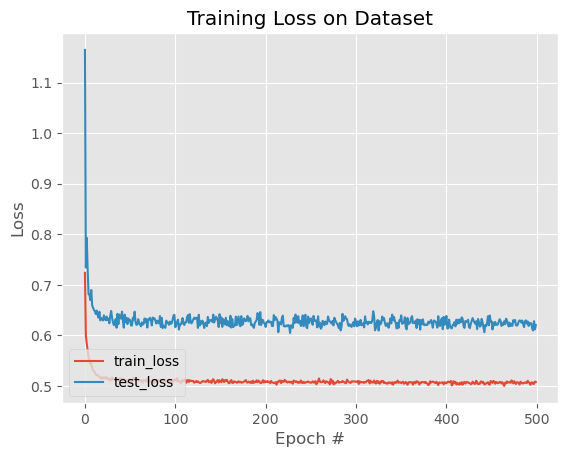

In [21]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(num_epochs)):
    # set the model in training mode
    unet.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y)
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        # loop over the validation set
        for (x, y) in testLoader:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            # make the predictions and calculate the validation loss
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y)
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
        avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(plot_path)
# serialize the model to disk
torch.save(unet, model_path)

In [42]:
def prepare_plot(original_image: np.ndarray, original_mask: np.ndarray, predicted_mask: np.ndarray) -> None:
    """Prepares a plot with three subplots showing the original image, the ground truth mask, and the predicted mask."""
    # Calculate the 1st and 99th percentiles of the original and predicted masks
    original_q1, original_q99 = np.percentile(original_mask, (1, 99))
    predicted_q1, predicted_q99 = np.percentile(predicted_mask, (1, 99))
    original_min, original_max = original_mask.min(), original_mask.max() 
    predicted_min, predicted_max = predicted_mask.min(), predicted_mask.max() 
    print(f"Original mask range: {original_min:.4f} - {original_max:.4f}")
    print(f"Original mask 1st and 99th percentiles: {original_q1:.4f} - {original_q99:.4f}")
    print(f"Predicted mask range: {predicted_min:.4f} - {predicted_max:.4f}")
    print(f"Predicted mask 1st and 99th percentiles: {predicted_q1:.4f} - {predicted_q99:.4f}")
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
    axes[0].imshow(original_image)
    axes[0].grid(False)
    axes[0].set_title("Image")
    axes[1].imshow(original_mask, cmap='gray', vmin=0, vmax=.45)
    axes[1].grid(False)
    axes[1].set_title("Original SEM")
    axes[2].imshow(predicted_mask, cmap='gray', vmin=0, vmax=.45)
    axes[2].grid(False)
    axes[2].set_title("Predicted SEM")
    axes[3].hist(original_mask.flatten(), bins=20, range=(0, .45), label='original', histtype='step')
    axes[3].hist(predicted_mask.flatten(), bins=20, range=(0, .45), label='prediction', histtype='step')
    axes[3].legend(loc='upper left')
    axes[3].grid(False)
    fig.tight_layout()
    plt.show()


def make_predictions(model: torch.nn.Module, image_path: str) -> None:
    """Takes a trained model and an image file path and generates a predicted mask."""
    model.eval()

    with torch.no_grad():
        
        # Load image and ground truth mask
        img_1 = np.array(Image.open(image_path).convert("RGB"), dtype=np.float32) / 255.0
        img_2_path = image_path.replace("PPL", "XPL")
        img_2 = np.array(Image.open(img_2_path).convert("RGB"), dtype=np.float32) / 255.0
        image = np.concatenate((img_1, img_2), axis=-1)
        original = image.copy()

        filename = os.path.split(image_path)[-1]
        ground_truth_path = os.path.join(mask_dataset_path, filename) 
        ground_truth_mask = np.array(Image.open(ground_truth_path).convert("L"), dtype=np.float32) / 255.0

        # Prepare input for model
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(device)

        # Generate predicted mask
        predicted_mask = model(image).squeeze()
        predicted_mask = torch.sigmoid(predicted_mask)
        predicted_mask = predicted_mask.cpu().numpy()
        
        # Visualize results
        prepare_plot(original[:,:,0:3], ground_truth_mask, predicted_mask)

In [23]:
# load the image paths in our testing file and randomly select 10 image paths
print("[INFO] loading up test image paths...")
imagePaths = open(test_paths).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)

[INFO] loading up test image paths...


In [24]:
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(model_path).to(device)

[INFO] load up model...


Original mask range: 0.0000 - 0.5961
Original mask 1st and 99th percentiles: 0.0392 - 0.3608
Predicted mask range: 0.0110 - 0.3348
Predicted mask 1st and 99th percentiles: 0.0790 - 0.3185


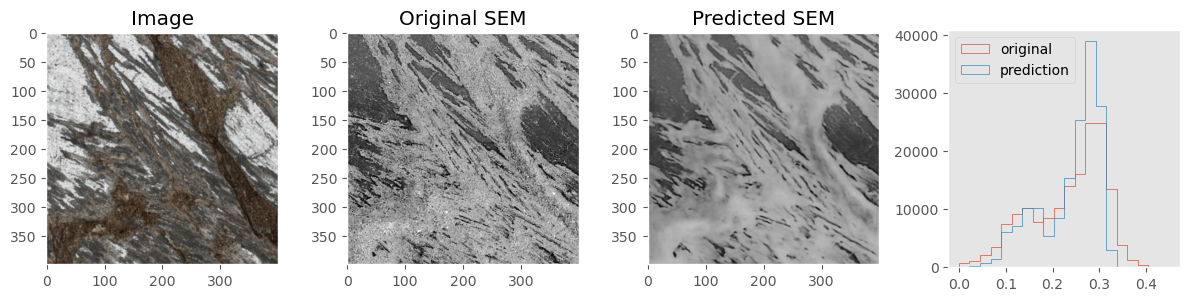

Original mask range: 0.0000 - 0.6392
Original mask 1st and 99th percentiles: 0.0706 - 0.3725
Predicted mask range: 0.0040 - 0.3608
Predicted mask 1st and 99th percentiles: 0.1161 - 0.3341


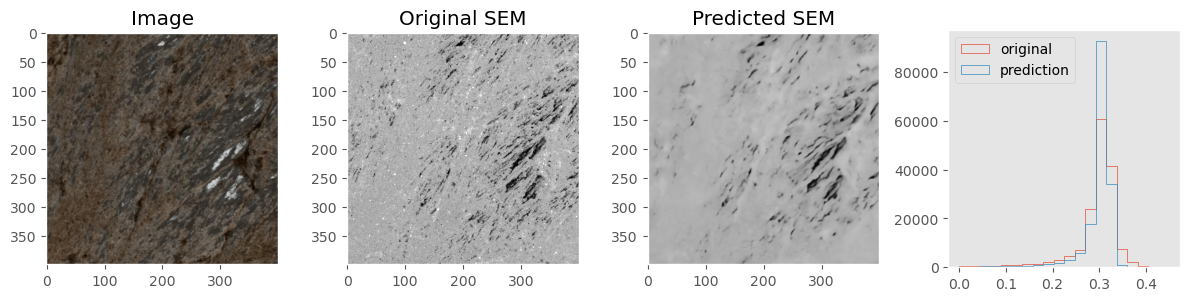

Original mask range: 0.0000 - 0.7804
Original mask 1st and 99th percentiles: 0.0392 - 0.4078
Predicted mask range: 0.0034 - 0.3762
Predicted mask 1st and 99th percentiles: 0.0625 - 0.3616


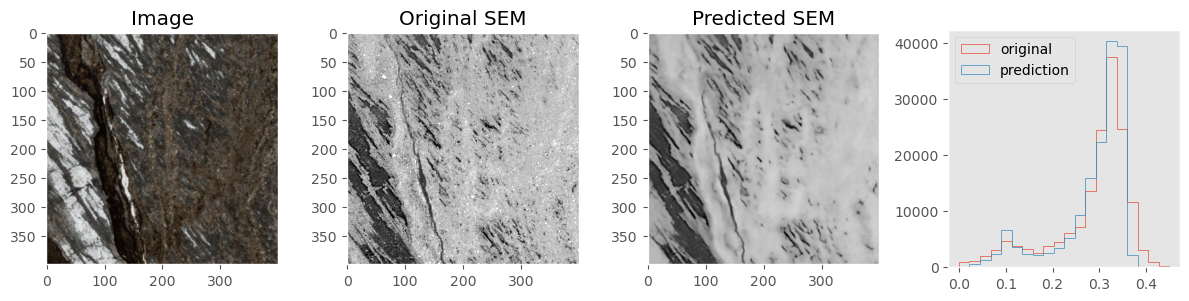

Original mask range: 0.0000 - 0.6353
Original mask 1st and 99th percentiles: 0.0118 - 0.3686
Predicted mask range: 0.0034 - 0.3548
Predicted mask 1st and 99th percentiles: 0.0398 - 0.3347


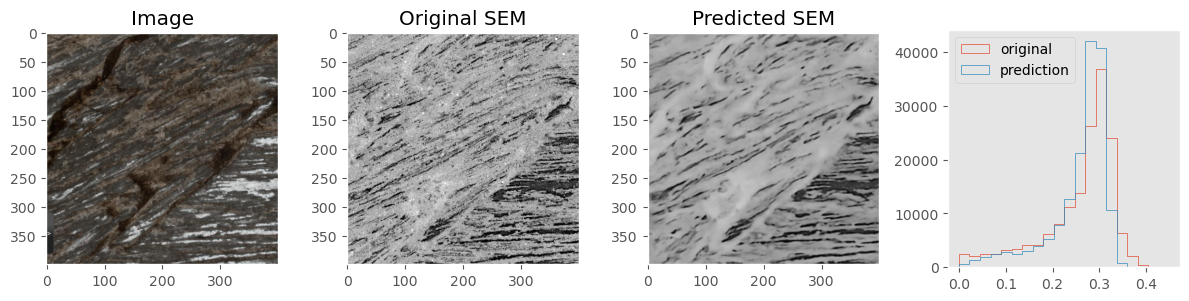

Original mask range: 0.0000 - 0.6549
Original mask 1st and 99th percentiles: 0.0235 - 0.3922
Predicted mask range: 0.0077 - 0.3784
Predicted mask 1st and 99th percentiles: 0.0508 - 0.3517


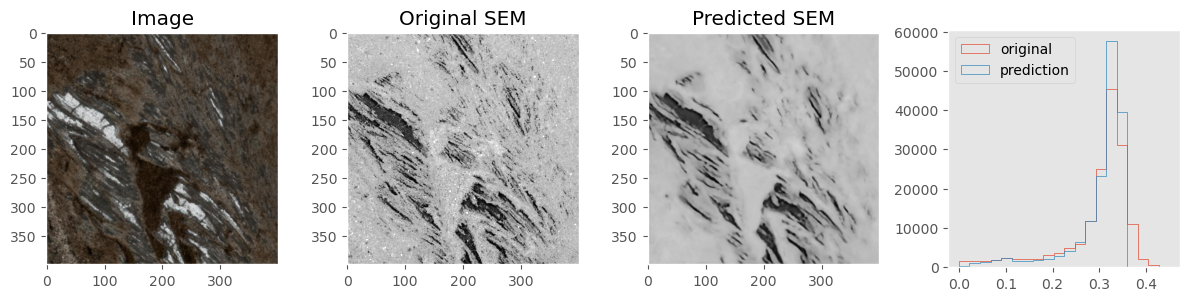

Original mask range: 0.0000 - 0.6627
Original mask 1st and 99th percentiles: 0.0784 - 0.3686
Predicted mask range: 0.0041 - 0.3665
Predicted mask 1st and 99th percentiles: 0.1045 - 0.3326


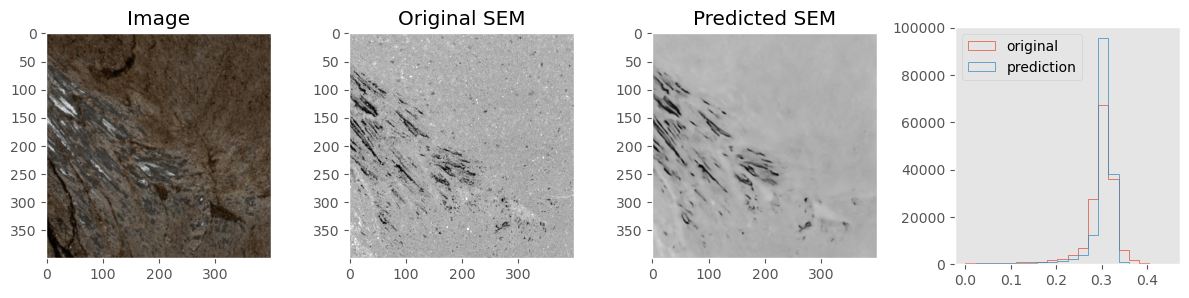

Original mask range: 0.0000 - 0.7137
Original mask 1st and 99th percentiles: 0.0667 - 0.4157
Predicted mask range: 0.0044 - 0.4581
Predicted mask 1st and 99th percentiles: 0.0996 - 0.3769


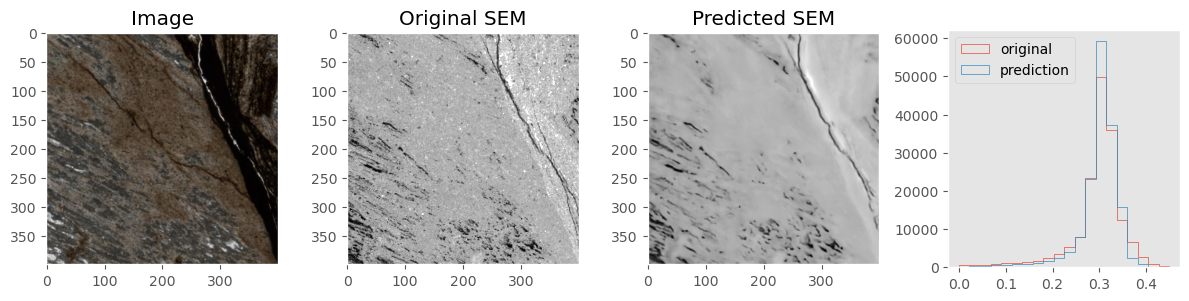

Original mask range: 0.0000 - 0.6510
Original mask 1st and 99th percentiles: 0.0118 - 0.3412
Predicted mask range: 0.0047 - 0.3357
Predicted mask 1st and 99th percentiles: 0.0312 - 0.3186


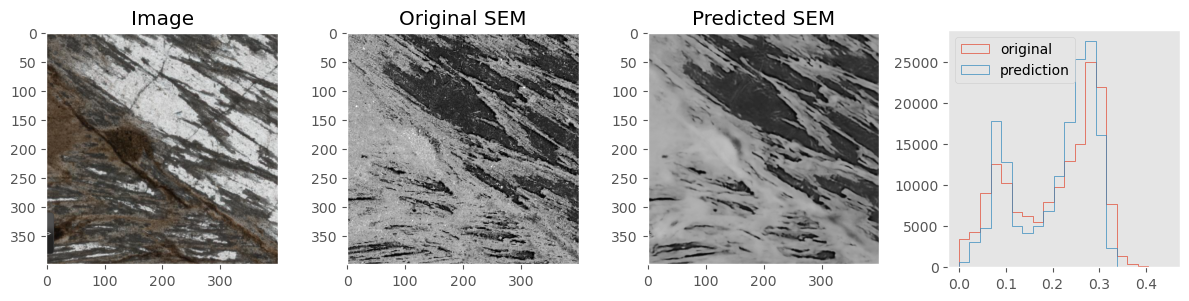

Original mask range: 0.0000 - 0.6431
Original mask 1st and 99th percentiles: 0.0314 - 0.3608
Predicted mask range: 0.0082 - 0.3374
Predicted mask 1st and 99th percentiles: 0.0698 - 0.3190


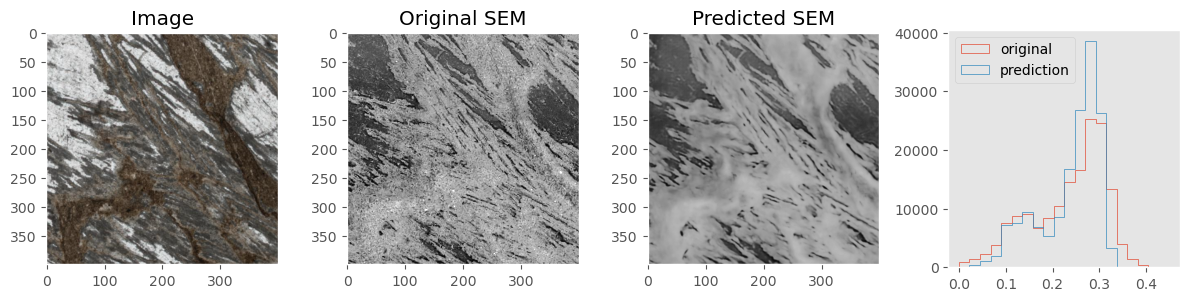

Original mask range: 0.0000 - 0.6863
Original mask 1st and 99th percentiles: 0.0863 - 0.3686
Predicted mask range: 0.0053 - 0.3440
Predicted mask 1st and 99th percentiles: 0.1137 - 0.3287


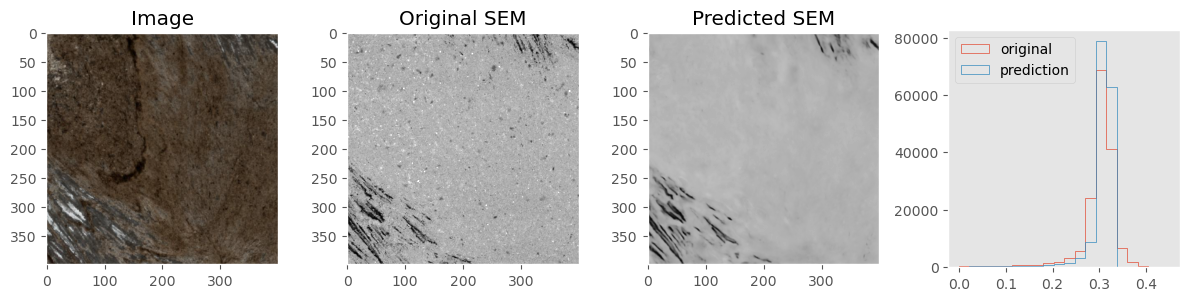

In [43]:
# iterate over the randomly selected test image paths
for path in imagePaths:
    # make predictions and visualize the results
    make_predictions(unet, path)